# Definitions and Environment

## Libraries and Settings

In [1]:
import os.path as osp
import time
import pickle
import os
from datetime import datetime
import warnings

import torch
from torch_geometric.nn import GATConv
from torch_geometric.nn.models import VGAE
import torch.nn.functional as F
import numpy as np
import random
import itertools
import networkx as nx
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import make_interp_spline

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Dataset, Data
from torch.nn import GRU
from torch_geometric.utils import to_dense_adj
from torch.distributions import Normal, kl_divergence


import matplotlib.pyplot as plt
import seaborn as sns

import pprint

In [2]:
# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Plot settings
if osp.exists("./files/paper.mplstyle"):
    plt.style.use("./files/paper.mplstyle")
    print("Using paper style")
else:
    print("Using default style")

Using paper style


In [4]:
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Functions (Processing)

In [5]:
def graphToEdgelist(g):
    """
    Returns the edge list of a networkx graph.
    Note that if the graph is undirected, the first node in the edge list has always the smaller index.
    g: networkx graph
    """
    edges = list(g.edges())

    # From edge list to a PyTorch tensor
    edge_index = torch.tensor(list(zip(*edges)), dtype=torch.long)

    return edge_index


def graphToNonEdgelist(g):
    """
    Returns the non-edge list of a networkx graph.
    g: networkx graph
    """
    not_edges = list(nx.non_edges(g))

    # From edge list to a PyTorch tensor
    not_edge_index = torch.tensor(list(zip(*not_edges)), dtype=torch.long)

    return not_edge_index


def graphToEdgeLabel(g, k, shuffle=True):
    """
    Returns k edges and k not edges to be tested.
    g: networkx graph
    k: number of edges to be labeled
    """
    # Get the edges and the not edges
    edges = list(nx.edges(g))
    not_edges = list(nx.non_edges(g))
    assert len(edges) > k, "k must be smaller than the number of edges"

    # Choose randomly k edges and k not edges
    true_edges_index = np.random.choice(len(edges), size=k, replace=False)
    true_not_edges_index = np.random.choice(len(not_edges), size=k, replace=False)

    true_edges = [edges[i] for i in true_edges_index]
    true_not_edges = [not_edges[i] for i in true_not_edges_index]

    # Cast them to a torch tensor
    true_edges_index = torch.tensor(list(zip(*true_edges)), dtype=torch.long)
    true_not_edges_index = torch.tensor(list(zip(*true_not_edges)), dtype=torch.long)

    # Merge the tensors
    edge_label_index = torch.cat([true_edges_index, true_not_edges_index], dim=1)

    # Create the labels
    edge_label = torch.cat([torch.ones(k), torch.zeros(k)], dim=0)

    # Shuffle the tensor
    if shuffle:
        shuffle_idx = torch.randperm(edge_label_index.size(1))
        edge_label_index = edge_label_index[:, shuffle_idx]
        edge_label = edge_label[shuffle_idx]

    return edge_label_index, edge_label


def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_inverse(z):
    return np.log(z/(1-z))


def getAllPairs(N):
    """
    Returns all the pairs of nodes in a undirected graph.
    N: number of nodes
    """
    pairs = list(itertools.combinations(range(N), 2))
    pairs_tensor = torch.tensor(pairs).t()

    return pairs_tensor


def edgelistToGraph(edge_list):
    """
    Returns a networkx graph from an edge list.
    edge_list: list of edges (tensor)
    """
    edge_list = edge_list.t().tolist()
    g = nx.Graph()
    g.add_edges_from(edge_list)
    return g

In [6]:
def corruptNetwork(g, f):
    """
    Corrupts a network by adding/removing edges.
    g: networkx graph
    f: corruption probability
    """
    g = g.copy()

    # Get the list of edges and non-edges of g
    edges = list(g.edges())
    not_edges = list(nx.non_edges(g))

    # Number of edges to be added/removed
    num_corrupted = int(np.floor(f * len(edges)))

    # Randomly select edges to remove
    edges_to_remove = random.sample(edges, num_corrupted)
    g.remove_edges_from(edges_to_remove)

    # Randomly select edges to add
    edges_to_add = random.sample(not_edges, num_corrupted)
    g.add_edges_from(edges_to_add)

    return g


def obtainFeatureMatrix(g, ZScore= False):
  """
  Obtains the feature matrix of a network.
  g: networkx graph
  """
  functions = [
      lambda g: [g.degree(n) for n in g.nodes()],
      lambda g: list(nx.betweenness_centrality(g).values()),
      lambda g: list(nx.closeness_centrality(g).values()),
      lambda g: list(nx.eigenvector_centrality(g).values()),
      lambda g: list(nx.katz_centrality_numpy(g).values()),
      lambda g: list(nx.pagerank(g).values()),
      lambda g: list(nx.load_centrality(g).values()),
      lambda g: list(nx.harmonic_centrality(g).values()),
      lambda g: list(nx.clustering(g).values())
  ]

  r = list(map(lambda f: f(g), functions))

  if ZScore:
      features = torch.tensor(r).T.numpy()

      scaler = StandardScaler()
      features = scaler.fit_transform(features)

  else:
      features = torch.tensor(r).T.numpy()

  return torch.tensor(features)

In [7]:
def compareGraphs(g, g_corrupted):
    """
    Function to compute missing and spurious interactions between two networkx graphs.
    """
    # Get the list of edges of g
    edges = list(nx.edges(g))
    
    # Get the list of edges of g_corrupted
    edges_corrupted = list(nx.edges(g_corrupted))
    
    # Compute the missing and spurious interactions
    missing_edges = list(set(edges) - set(edges_corrupted))
    spurious_edges = list(set(edges_corrupted) - set(edges))

    return len(missing_edges), len(spurious_edges)


def compareEdgeLists(edge_list, edge_list_corrupted):
    """
    Function to compute missing and spurious interactions between two edge lists.
    Be careful, this function assumes a directed graph: order matters!
    """
    edges_set = set(tuple(edge.tolist()) for edge in edge_list.T)
    edges_set_corrupted = set(tuple(edge.tolist()) for edge in edge_list_corrupted.T)

    missing_edges = list(edges_set - edges_set_corrupted)
    spurious_edges = list(edges_set_corrupted - edges_set)

    return len(missing_edges), len(spurious_edges)

In [8]:
def customGraphData(g):
    """
    Prepare the graph data for PyTorch Geometric from a networkx graph.
    """
    # Get the edge list
    edge_index = graphToEdgelist(g)

    # Get the node feature matrix
    node_features = obtainFeatureMatrix(g, False)

    # Set node labels to zero
    labels = torch.zeros(g.number_of_nodes())

    return edge_index, node_features, labels


## Classes

In [ ]:
# Model from the paper (Kipf and Welling)
class NetConv(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        
        # First Graph Convolution Layer: transforms input features to hidden layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        
        # Second Graph Convolution Layer: transforms hidden features to output layer
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        self.reset_parameters()  # Initialize model parameters

    def reset_parameters(self):
        # Reset parameters of the GCN layers to their initial values
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def encode(self, x, edge_index):
        # Pass input features through the first convolutional layer with ReLU activation
        x = self.conv1(x, edge_index).relu()
        
        # Pass through the second convolutional layer to get latent representation `z`
        z = self.conv2(x, edge_index)
        return z

    def decode(self, z, edge_label_index):
        # Decoding for link prediction: computes similarity score 
        # between node pairs specified by `edge_label_index`
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Decodes all potential links by computing the similarity matrix `prob_adj`
        prob_adj = z @ z.t()  # Dot product of latent vectors
        # Returns pairs of nodes with a positive link probability
        return (prob_adj > 0).nonzero(as_tuple=False).t()


In [ ]:
# Model from the paper with dropout and batch normalization
class NetConvPlus(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        
        # Graph Convolution Layers for feature transformation
        self.conv1 = GCNConv(in_channels, hidden_channels)  # First layer
        self.conv2 = GCNConv(hidden_channels, out_channels)  # Second layer
        
        # Batch Normalization for regularizing each layer
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # Hidden layer
        self.bn2 = torch.nn.BatchNorm1d(out_channels)     # Output layer
        
        # Dropout rate to prevent overfitting
        self.dropout = dropout 
        self.reset_parameters()  # Initialize model parameters

    def reset_parameters(self):
        # Reset parameters for convolution and batch normalization layers
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def encode(self, x, edge_index):
        # Feature encoding with dropout, convolution, batch norm, and ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout on input
        x = self.conv1(x, edge_index)  # First convolution
        x = self.bn1(x)                # Batch normalization on hidden layer
        x = F.relu(x)                  # ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout on hidden layer
        
        z = self.conv2(x, edge_index)  # Second convolution
        z = self.bn2(z)                # Batch normalization on output layer
        return z

    def decode(self, z, edge_label_index):
        # Link prediction function: computes similarity score for node pairs
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Predicts links between all node pairs by computing a probability adjacency matrix
        prob_adj = z @ z.t()  # Matrix multiplication of latent vectors
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()  # Return pairs with prob > 0.5


In [ ]:
# Recurrent Layer model integrating Graph Convolutional Networks and GRU
class NetRecurrent(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        
        # First Graph Convolution Layer: transforms input features to hidden representation
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second Graph Convolution Layer: transforms hidden representation to output features
        self.conv2 = GCNConv(hidden_channels, out_channels)
        
        # Gated Recurrent Unit (GRU) for capturing sequential dependencies
        self.gru = GRU(out_channels, hidden_channels, batch_first=True)
        
        # Batch Normalization layers for regularizing the outputs of the convolution layers
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)  # For hidden layer
        self.bn2 = torch.nn.BatchNorm1d(out_channels)     # For output layer
        
        # Dropout rate for regularization
        self.dropout = dropout
        self.reset_parameters()  # Initialize model parameters

    def reset_parameters(self):
        # Reset parameters of the convolution and batch normalization layers
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()
        self.bn1.reset_parameters()
        self.bn2.reset_parameters()

    def encode(self, x, edge_index):
        # Feature encoding with dropout, convolution, batch normalization, and ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Apply dropout to input
        x = self.conv1(x, edge_index)  # First convolution layer
        x = self.bn1(x)                # Batch normalization on hidden layer
        x = F.relu(x)                  # Apply ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout on hidden layer
        
        z = self.conv2(x, edge_index)  # Second convolution layer
        z = self.bn2(z)                # Batch normalization on output layer
        
        # Adding GRU layer to capture sequential relationships
        z, _ = self.gru(z.unsqueeze(0))  # Unsqueeze to add sequence dimension
        return z.squeeze(0)  # Remove the sequence dimension

    def decode(self, z, edge_label_index):
        # Decoding function for link prediction: computes similarity score 
        # between node pairs specified by `edge_label_index`
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Predicts links between all node pairs by computing a similarity matrix
        prob_adj = z @ z.t()  # Matrix multiplication of latent representations
        # Returns pairs of nodes with a link probability greater than 0.5
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()


In [ ]:
# Attention Layer model using Graph Attention Networks (GAT)
class NetAttention(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.5):
        super().__init__()
        
        # First Graph Attention Layer: transforms input features to hidden representation
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        
        # Second Graph Attention Layer: transforms hidden representation to output features
        # Note: heads=1 and concat=False for final layer to produce output without concatenation
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False)
        
        # Batch Normalization for the outputs of the first attention layer
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels * heads)
        
        # Dropout rate for regularization
        self.dropout = dropout

    def reset_parameters(self):
        # Reset parameters of the attention and batch normalization layers
        self.gat1.reset_parameters()
        self.gat2.reset_parameters()
        self.bn1.reset_parameters()

    def encode(self, x, edge_index):
        # Feature encoding with dropout, attention, batch normalization, and ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Apply dropout to input
        x = self.gat1(x, edge_index)  # First GAT layer
        x = self.bn1(x)                # Batch normalization on hidden layer
        x = F.relu(x)                  # Apply ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout on hidden layer
        
        z = self.gat2(x, edge_index)  # Second GAT layer
        return z  # Return the output representation

    def decode(self, z, edge_label_index):
        # Decoding function for link prediction: computes similarity score 
        # between node pairs specified by `edge_label_index`
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Predicts links between all node pairs by computing a similarity matrix
        prob_adj = z @ z.t()  # Matrix multiplication of latent representations
        # Returns pairs of nodes with a link probability greater than 0.5
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()


In [9]:
# Variational Autoencoder model using Graph Convolutional Networks
class NetVAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        
        # First Graph Convolution Layer: transforms input features to hidden representation
        self.conv1 = GCNConv(in_channels, hidden_channels)
        
        # Layers for encoding mean and log standard deviation of the latent representation
        self.conv_mu = GCNConv(hidden_channels, out_channels)   # Mean layer
        self.conv_logstd = GCNConv(hidden_channels, out_channels)  # Log standard deviation layer
        
        # Batch Normalization for the hidden layer
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        
        # Dropout rate for regularization
        self.dropout = dropout
        self.reset_parameters()  # Initialize model parameters

    def reset_parameters(self):
        # Reset parameters of the convolution and batch normalization layers
        self.conv1.reset_parameters()
        self.conv_mu.reset_parameters()
        self.conv_logstd.reset_parameters()
        self.bn1.reset_parameters()

    def encode(self, x, edge_index):
        # Feature encoding with dropout, convolution, batch normalization, and ReLU activation
        x = F.dropout(x, p=self.dropout, training=self.training)  # Apply dropout to input
        x = self.conv1(x, edge_index)  # First convolution layer
        x = self.bn1(x)                # Batch normalization on hidden layer
        x = F.relu(x)                  # Apply ReLU activation

        # Compute the mean and log standard deviation for the latent representation
        z_mu = self.conv_mu(x, edge_index)        # Mean of the latent distribution
        z_logstd = self.conv_logstd(x, edge_index)  # Log std of the latent distribution
        return z_mu, z_logstd  # Return both for reparameterization

    def reparameterize(self, mu, logstd):
        # Reparameterization trick for generating samples from the latent distribution
        if self.training:
            std = torch.exp(logstd)  # Compute standard deviation
            eps = torch.randn_like(std)  # Sample from standard normal distribution
            return eps.mul(std).add_(mu)  # Combine to produce a sample
        else:
            return mu  # During inference, return mean

    def decode(self, z, edge_label_index):
        # Decoding function for link prediction: computes similarity score 
        # between node pairs specified by `edge_label_index`
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        # Predicts links between all node pairs by computing a similarity matrix
        prob_adj = z @ z.t()  # Matrix multiplication of latent representations
        # Returns pairs of nodes with a link probability greater than 0.5
        return (prob_adj > 0.5).nonzero(as_tuple=False).t()

    def forward(self, x, edge_index):
        # Forward pass through the model
        z_mu, z_logstd = self.encode(x, edge_index)  # Encoding step
        z = self.reparameterize(z_mu, z_logstd)  # Reparameterization step
        return z, z_mu, z_logstd  # Return the sample, mean, and log std


In [10]:
class CustomGraphDataset(Dataset):
    def __init__(self, root, edge_index, node_features, labels, transform=None):
        super(CustomGraphDataset, self).__init__(root, transform=transform)

        # Prepare data
        self.data = Data(x=node_features, edge_index=edge_index, y=labels)

    def len(self):
        return 1  # Returning 1 since we have a single graph

    def get(self, idx):
        # Return the graph data for index `idx` (used in transform)
        return self.data

In [11]:
class TrainerVAE:
    def __init__(self, model, optimizer, device='cpu'):
        self.model = model  # The VAE model
        self.optimizer = optimizer  # Optimizer for model training
        self.device = device  # Device to run the model (CPU or GPU)
        self.model.to(device)  # Move the model to the specified device
        self.best_model_state_dict = None  # To store the best model parameters

    def kl_divergence(self, mu, logstd):
        # Compute the Kullback-Leibler divergence between the learned distribution and the prior
        kl_div = -0.5 * torch.mean(1 + 2 * logstd - mu.pow(2) - logstd.exp().pow(2))
        return kl_div
    
    def loss_function(self, recon_loss, mu, logstd):
        # Combine reconstruction loss and KL divergence to form the total loss
        kl_div = self.kl_divergence(mu, logstd)
        return recon_loss + kl_div
    
    def train(self, train_data, g_train=0, corrupt=False, corrupt_percentage=0.1, shuffle=False):
        # Set the model to training mode
        self.model.train()
        self.optimizer.zero_grad()  # Zero the gradients before the backward pass

        # Corrupt the training graph if specified
        if corrupt:
            g_corrupted = corruptNetwork(g_train, corrupt_percentage)
            train_edge_index_corrupted = graphToEdgelist(g_corrupted)
        else:
            train_edge_index_corrupted = train_data.edge_index

        # Encode the input data to obtain latent representation
        mu, logstd = self.model.encode(train_data.x.to(self.device), train_edge_index_corrupted.to(self.device))
        z = self.model.reparameterize(mu, logstd)  # Sample from the latent space

        # Generate negative samples for the training
        neg_edge_index = negative_sampling(
            edge_index=train_edge_index_corrupted, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

        # Combine positive and negative edges for the loss calculation
        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([train_data.edge_label,
                                train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        # Shuffle edge indices and labels if specified
        if shuffle:
            shuffle_idx = torch.randperm(edge_label_index.size(1))
            edge_label_index = edge_label_index[:, shuffle_idx]
            edge_label = edge_label[shuffle_idx]

        # Decode to get the output probabilities
        out = self.model.decode(z, edge_label_index.to(self.device)).view(-1)

        # Compute the reconstruction loss using binary cross-entropy
        recon_loss = F.binary_cross_entropy_with_logits(out, edge_label.to(self.device).float())
        total_loss = self.loss_function(recon_loss, mu, logstd)  # Compute the total loss

        total_loss.backward()  # Backpropagate the loss
        self.optimizer.step()  # Update the model parameters

        # Calculate accuracy and AUC for the predictions
        accuracy = ((out > 0.5).float() == edge_label.to(self.device)).float().mean().item()
        auc = roc_auc_score(edge_label.cpu().numpy(), out.cpu().detach().numpy())

        return total_loss.item(), accuracy, auc

    @torch.no_grad()
    def test(self, data, corrupt=False, corrupt_percentage=0.1, full_output=False):
        # Set the model to evaluation mode
        self.model.eval()

        # Corrupt the test graph if specified
        if corrupt:
            g = nx.from_edgelist(data.edge_index.t().tolist())
            g_corrupted = corruptNetwork(g, corrupt_percentage)
            test_edge_index_corrupted = graphToEdgelist(g_corrupted)
        else:
            test_edge_index_corrupted = data.edge_index

        # Encode the input data for testing
        mu, logstd = self.model.encode(data.x.to(self.device), test_edge_index_corrupted.to(self.device))
        z = self.model.reparameterize(mu, logstd)  # Sample from the latent space

        # Decode to get the output probabilities for the edge labels
        out = self.model.decode(z, data.edge_label_index.to(self.device)).view(-1).sigmoid()

        # Convert outputs and labels to CPU for further processing
        out_cpu = out.cpu().numpy()
        label_cpu = data.edge_label.cpu().numpy()

        # Calculate accuracy and AUC for the predictions
        accuracy = ((out > 0.5).float().cpu().numpy() == label_cpu).mean()
        auc = roc_auc_score(label_cpu, out_cpu)

        # Return either full output or just accuracy and AUC
        if full_output:
            return accuracy, auc, out_cpu, label_cpu
        else:
            return accuracy, auc

    def train_model(self, train_data, val_data, epochs=100, early_stopping=False, early_stopping_patience=10,
                    early_stopping_threshold=1e-2, corrupt=False, corrupt_percentage=0.1, save_dir='data',
                    run_timestamp=None, save_best_model=False):
        
        # Convert the training data to a networkx graph for corruption
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        os.makedirs(save_dir, exist_ok=True)  # Create directory for saving models if it doesn't exist

        best_val_auc = 0  # Initialize the best validation AUC
        # Initialize lists to store metrics over epochs
        train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history = [np.zeros(epochs) for _ in range(5)]
        early_stopping_counter = 0  # Counter for early stopping

        # Timestamp for saving model
        run_timestamp = time.strftime("%Y%m%d-%H%M%S")

        for epoch in tqdm(range(1, epochs + 1)):
            # Train the model and evaluate on validation data
            loss, train_accuracy, train_auc = self.train(train_data, g_train, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            val_acc, val_auc = self.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)

            # Store the metrics for this epoch
            loss_history[epoch - 1] = loss
            train_acc_history[epoch - 1] = train_accuracy
            train_auc_history[epoch - 1] = train_auc
            val_acc_history[epoch - 1] = val_acc
            val_auc_history[epoch - 1] = val_auc

            # Check for improvement in validation AUC for early stopping
            if val_auc - best_val_auc > early_stopping_threshold:
                best_val_auc = val_auc
                self.best_model_state_dict = self.model.state_dict()  # Save the best model parameters
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            # Implement early stopping if needed
            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")
                return (train_acc_history[:epoch], train_auc_history[:epoch],
                        val_acc_history[:epoch], val_auc_history[:epoch], 
                        loss_history[:epoch], run_timestamp)
            
            # Save the best model to file if specified
            if save_best_model:
                model_path = os.path.join(save_dir, f'best_model_{run_timestamp}.pth')
                torch.save(self.best_model_state_dict, model_path)

        # Return metrics for the completed training run
        return train_acc_history[:epoch], train_auc_history[:epoch], val_acc_history[:epoch], val_auc_history[:epoch], loss_history[:epoch], run_timestamp


In [ ]:
# Trainer AE
class TrainerAE:
    def __init__(self, model, optimizer, criterion, device='cpu'):
        # Initialize the trainer with model, optimizer, criterion, and device
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.model.to(device)  # Move the model to the specified device (CPU or GPU)
        self.best_model_state_dict = None  # To store the best model's state

    def hits_at_k(self, predicted_edges, true_edges, k=20):
        # Calculate the hits@k metric for link prediction
        top_k_edges = predicted_edges[:k]  # Get the top k predicted edges

        # Create a set of top k edges for efficient look-up
        top_k_set = set((src, tgt) for src, tgt, _ in top_k_edges)
        hits = len(top_k_set.intersection(true_edges))  # Count hits
        hits_at_k_score = hits / k * 100  # Calculate hits@k percentage

        return hits_at_k_score
    
    def mean_reciprocal_rank(self, out, edge_label, k=None):
        # Compute the Mean Reciprocal Rank (MRR) for the predicted output
        if k is None:
            k = len(out)  # If k is not specified, use the length of output

        ranks = torch.argsort(out, descending=True)[:k]  # Get indices of top k predictions

        reciprocal_ranks_sum = 0.0  # Initialize sum of reciprocal ranks
        num_positive_samples = 0  # Counter for positive samples

        for rank_index in ranks:
            if edge_label[rank_index] == 1:  # Check if the predicted edge is positive
                reciprocal_rank = 1.0 / (num_positive_samples + 1)  # Calculate reciprocal rank
                reciprocal_ranks_sum += reciprocal_rank  # Update sum
                num_positive_samples += 1  # Increment count of positive samples

        if num_positive_samples == 0:
            return 0.0  # Return 0 if no positive samples

        return reciprocal_ranks_sum / num_positive_samples  # Return average reciprocal rank

    def train(self, train_data, g_train=0, corrupt=False, corrupt_percentage=0.1, shuffle=False):
        # Train the model on the provided training data
        self.model.train()  # Set model to training mode
        self.optimizer.zero_grad()  # Reset gradients

        # (Possibly) corrupt the network
        if corrupt:
            g_corrupted = corruptNetwork(g_train, corrupt_percentage)  # Corrupt the training graph
            print("The network has been corrupted.")
            train_edge_index_corrupted = graphToEdgelist(g_corrupted)  # Convert to edge list
        else:
            train_edge_index_corrupted = train_data.edge_index  # Use original edge index

        # Encoding
        z = self.model.encode(train_data.x.to(self.device), train_edge_index_corrupted.to(self.device))  # Encode input data

        # Negative sampling
        neg_edge_index = negative_sampling(
            edge_index=train_edge_index_corrupted, num_nodes=train_data.num_nodes,
            num_neg_samples=train_data.edge_label_index.size(1), method='sparse'
        )  # Generate negative samples

        # Combine positive and negative edge indices and labels
        edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
        edge_label = torch.cat([train_data.edge_label, 
                                train_data.edge_label.new_zeros(neg_edge_index.size(1))], dim=0)

        # (Possibly) shuffle the edge_label_index
        if shuffle:
            shuffle_idx = torch.randperm(edge_label_index.size(1))  # Generate random indices
            edge_label_index = edge_label_index[:, shuffle_idx]  # Shuffle edge indices
            edge_label = edge_label[shuffle_idx]  # Shuffle corresponding labels

        # Decoding
        out = self.model.decode(z, edge_label_index.to(self.device)).view(-1)  # Decode the encoded representations
        
        # Loss and backpropagation
        loss = self.criterion(out, edge_label.to(self.device))  # Calculate loss
        loss.backward()  # Backpropagate the gradients
        self.optimizer.step()  # Update model parameters

        # Performance metrics
        accuracy = ((out > 0.5).float() == edge_label.to(self.device)).float().mean().item()  # Calculate accuracy
        auc = roc_auc_score(edge_label.cpu().numpy(), out.cpu().detach().numpy())  # Calculate AUC

        return loss.item(), accuracy, auc  # Return loss, accuracy, and AUC

    @torch.no_grad()
    def test(self, data, corrupt=False, corrupt_percentage=0.1, full_output=False):
        # Evaluate the model on the test data
        self.model.eval()  # Set model to evaluation mode

        # (Possibly) corrupt the network
        if corrupt:
            g = nx.from_edgelist(data.edge_index.t().tolist())  # Convert edge index to networkx graph
            g_corrupted = corruptNetwork(g, corrupt_percentage)  # Corrupt the graph
            test_edge_index_corrupted = graphToEdgelist(g_corrupted)  # Convert to edge list
            print(f"The network has been corrupted with {corrupt_percentage * 100}% corruption.")
        else:
            test_edge_index_corrupted = data.edge_index  # Use original edge index

        # Encoding and decoding
        z = self.model.encode(data.x.to(self.device), test_edge_index_corrupted.to(self.device))  # Encode input data
        out = self.model.decode(z, data.edge_label_index.to(self.device)).view(-1).sigmoid()  # Decode and apply sigmoid

        out_cpu = out.cpu().numpy()  # Move output to CPU
        label_cpu = data.edge_label.cpu().numpy()  # Move labels to CPU

        # Performance metrics
        accuracy = ((out > 0.5).float().cpu().numpy() == label_cpu).mean()  # Calculate accuracy
        auc = roc_auc_score(label_cpu, out_cpu)  # Calculate AUC

        if full_output:
            return accuracy, auc, out_cpu, label_cpu  # Return detailed metrics if requested
        else:
            return accuracy, auc  # Return basic metrics

    def train_model(self, train_data, val_data, epochs=100, early_stopping=False, early_stopping_patience=10, 
                    early_stopping_threshold=1e-2, corrupt=False, corrupt_percentage=0.1, 
                    save_dir='data', run_timestamp=None, save_best_model=False):
        
        # Get the networkx graphs from the edge lists (used if corrupt=True)
        g_train = nx.from_edgelist(train_data.edge_index.t().tolist())
        
        # Create save directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Initialize variables
        best_val_auc = 0  # Best validation AUC
        train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history = [np.zeros(epochs) for _ in range(5)]
        
        early_stopping_counter = 0  # Counter for early stopping
        total_train_time = 0  # Total training time
        total_val_time = 0  # Total validation time

        # Initialize test metrics
        final_test_auc = None  
        final_test_acc = None 
        final_test_mrr = None 

        # Generate a unique timestamp for the run
        run_timestamp = time.strftime("%Y%m%d-%H%M%S")

        # Training epochs
        for epoch in tqdm(range(1, epochs + 1)):
            # Training
            train_start_time = time.time()
            loss, train_accuracy, train_auc = self.train(train_data, g_train, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            train_duration = time.time() - train_start_time  # Calculate training duration
            total_train_time += train_duration
            
            # Validation
            val_start_time = time.time()
            val_acc, val_auc = self.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)
            val_duration = time.time() - val_start_time  # Calculate validation duration
            total_val_time += val_duration
            
            # Save metrics
            loss_history[epoch - 1] = loss
            train_acc_history[epoch - 1] = train_accuracy
            train_auc_history[epoch - 1] = train_auc
            val_acc_history[epoch - 1] = val_acc
            val_auc_history[epoch - 1] = val_auc

            # Evaluate best model
            if val_auc - best_val_auc > early_stopping_threshold:
                best_val_auc = val_auc  # Update best validation AUC
                best_epoch = epoch  # Record the epoch
                self.best_model_state_dict = self.model.state_dict()  # Save best model weights
                early_stopping_counter = 0  # Reset early stopping counter
            else:
                early_stopping_counter += 1  # Increment counter if no improvement

            # Early stopping
            if early_stopping and early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch}.")  # Print stopping message
                return (train_acc_history[:epoch], train_auc_history[:epoch],
                        val_acc_history[:epoch], val_auc_history[:epoch], 
                        loss_history[:epoch],


## Functions (Helper and Figures)

In [12]:
def count_parameters(model):
    """
    Counts the number of trainable parameters in a PyTorch model.
    """
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params


def scan_nchannels(dataset, hidden_channels, out_channels, epochs=300, corrupt=False, corrupt_percentage=0.1):
    # Get the training, validation and test data
    train_data, val_data, test_data = dataset[0]

    # Initialize the model
    model = NetConvPlus(dataset.num_features, hidden_channels, out_channels).to(device)

    # Set up the optimizer and loss function
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()

    # Initialize the trainer with the model, optimizer, and criterion
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and evaluate
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=epochs,
        early_stopping=True,
        early_stopping_patience=200,
    )
    
    best_model = NetConvPlus(dataset.num_features, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data, corrupt=corrupt, corrupt_percentage=corrupt_percentage)

    # Return detailed results
    return final_test_auc, final_test_acc


def scan_lr(dataset, learning_rate):
    # Get the training, validation and test data
    train_data, val_data, test_data = dataset[0]

    hidden_channels = 64
    out_channels = 32
    model = NetConvPlus(dataset.num_features, hidden_channels, out_channels).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    # Initialize the trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=400,
        early_stopping=True,
        early_stopping_patience=100,
    )

    best_model = TrainerAE(dataset.num_features, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data)
    

    return final_test_auc, final_test_acc 


def scan_dropout(dataset, dropout):
    # Get the training, validation and test data
    train_data, val_data, test_data = dataset[0]

    hidden_channels = 64
    out_channels = 32
    model = NetConvPlus(dataset.num_features, hidden_channels, out_channels, dropout=dropout).to(device)  
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.BCEWithLogitsLoss()
    # Initialize the trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model and get evaluation results# Assicurati di passare g_val e g_test alla funzione train_model
    _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data=train_data,
        val_data=val_data,
        epochs=400,
        early_stopping=True,
        early_stopping_patience=200
    )

    best_model = NetConvPlus(dataset.num_features, hidden_channels, out_channels, dropout).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    final_test_acc, final_test_auc = trainer.test(val_data)
    

    return final_test_auc, final_test_acc

In [13]:
def plot_training_ts(train_acc_history, train_auc_history, 
                     val_acc_history, val_auc_history, loss_history):
    """
    Plot training history of a model (accuracy, AUC, loss).
    """
    fontsize = 20

    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    ax[0].plot(train_acc_history, label='Train', color='seagreen', lw=2)
    ax[0].plot(val_acc_history, label='Validation', color='firebrick', lw=2)
    ax[0].set_title('Accuracy', fontsize=fontsize*1.5)
    ax[0].legend(fontsize=fontsize)
    ax[0].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[0].set_ylabel('Accuracy', fontsize=fontsize*1.2)
    ax[0].set_ylim(0.4, 1)
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)

    ax[1].plot(train_auc_history, label='Train', color='seagreen', lw=2)
    ax[1].plot(val_auc_history, label='Validation', color='firebrick', lw=2)
    ax[1].set_title('AUC', fontsize=fontsize*1.5)
    ax[1].legend(fontsize=fontsize)
    ax[1].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[1].set_ylabel('AUC', fontsize=fontsize*1.2)
    ax[1].set_ylim(0.4, 1)
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)

    ax[2].plot(loss_history, color='royalblue', lw=2)
    ax[2].set_title('Loss', fontsize=fontsize*1.5)
    ax[2].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[2].set_ylabel('Loss', fontsize=fontsize*1.2)
    ax[2].set_yscale('log')
    ax[2].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[2].tick_params(axis='both', which='minor', labelsize=fontsize)

    plt.tight_layout()

    return fig, ax


def plot_derivatives(val_acc_history, val_auc_history):
    """
    Plot the time derivatives of the AUC and accuracy.
    """
    fontsize = 20
    gradient_step = 3
    colors = sns.color_palette("husl", 2)

    fig, ax = plt.subplots(figsize=(10, 5))

    x = np.arange(0, 200, gradient_step)
    ax.plot(x, np.gradient(val_auc_history[:200:gradient_step]), label='AUC', color=colors[0])
    ax.plot(x, np.gradient(val_acc_history[:200:gradient_step]), label='Accuracy', color=colors[1])
    ax.plot(x, np.zeros((len(x))), 'k--')
    ax.set_title('Derivative of AUC and Accuracy', fontsize=fontsize*1.5)
    ax.legend(fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax.set_ylabel('Derivative', fontsize=fontsize*1.2)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax.set_ylim(-0.075, 0.075)

    plt.tight_layout()
    return fig, ax


def plot_performance(train_acc_history, train_auc_history, 
                     val_acc_history, val_auc_history, xlog=False):
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fontsize=40
    lw = 4

    ax[0].plot(train_acc_history, label='Traininig', color='seagreen', lw=lw)
    ax[0].plot(val_acc_history, label='Validation', color='firebrick', lw=lw)
    ax[0].set_title('Accuracy', fontsize=fontsize*1.3)
    ax[0].legend(loc="lower right", fontsize=fontsize)
    ax[0].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[0].set_ylabel('Accuracy', fontsize=fontsize*1.2)
    ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[0].set_ylim(0.25, 1.05)
    if xlog: ax[0].set_xscale('log')

    ax[1].plot(train_auc_history, label='Training', color='seagreen', lw=lw)
    ax[1].plot(val_auc_history, label='Validation', color='firebrick', lw=lw)
    ax[1].set_title('AUC', fontsize=fontsize*1.3)
    ax[1].legend(loc="lower right", fontsize=fontsize)
    ax[1].set_xlabel('Epoch', fontsize=fontsize*1.2)
    ax[1].set_ylabel('AUC', fontsize=fontsize*1.2)
    ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[1].set_ylim(0.25, 1.05)
    if xlog: ax[1].set_xscale('log')

    plt.tight_layout()
    return fig, ax

In [14]:
def get_histograms(train_data, val_data, model, trainer, checks):
    model = model.reset_parameters()
    
    # Get histograms 
    out, label, auc, accuracy = [], [], [], []
    for i in range(max(checks) + 1):
        if i in checks:
          accuracy_i, auc_i, out_i, label_i = trainer.test(val_data, full_output=True)
          out.append(out_i)
          label.append(label_i)
          auc.append(auc_i)
          accuracy.append(accuracy_i)
        
        trainer.train(train_data)

    return out, label, auc, accuracy, checks


def plot_histograms(out, label, auc, accuracy, checks):
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))
    nbins = 20
    fontsize=40

    colors = sns.color_palette("deep", 2)
    for i, (out_i, label_i) in enumerate(zip(out, label)):
        ax[i].hist(out_i[label_i == 0], bins=nbins, alpha=0.3, label='Negative', density=True)
        ax[i].hist(out_i[label_i == 1], bins=nbins, alpha=0.3, label='Positive', density=True)
        sns.kdeplot(out_i[label_i == 0], ax=ax[i], color=colors[0])
        sns.kdeplot(out_i[label_i == 1], ax=ax[i], color=colors[1])
        ax[i].set_title(f'Epoch: {checks[i]}', fontsize=fontsize*1.2)
        #ax[i].set_xlim(0.5, 1.05)
        ax[i].set_xlabel('Output', fontsize=fontsize)
        ax[i].set_ylabel('Density', fontsize=fontsize)
        ax[i].tick_params(axis='both', which='major', labelsize=fontsize)
        ax[i].tick_params(axis='both', which='minor', labelsize=fontsize)
        ax[i].set_yticks([]) # Remove y-ticks
        legend = ax[i].legend(loc="upper right", fontsize=fontsize*0.6)
        bbox = legend.get_window_extent(fig.canvas.get_renderer()).transformed(ax[i].transAxes.inverted())
        x_text, y_text = 0.05, bbox.y0 + 0.03
        ax[i].text(x_text, y_text, f'AUC: {auc[i]:.2f}\nAccuracy: {accuracy[i]:.2f}', fontsize=fontsize*0.75, 
                transform=ax[i].transAxes, ha='left')
        
    plt.tight_layout()
    return fig, ax

In [15]:
def plot_percentage(xlabel, percentages, test_accuracy_auc_mean, test_accuracy_auc_std, 
                    test_accuracy_acc_mean, test_accuracy_acc_std):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fontsize=30
    lw=3
    colors = sns.color_palette("husl", 2)

    # Plot accuracy
    percentages_smooth = np.linspace(np.min(percentages), np.max(percentages), 300)
    mean_spline = make_interp_spline(percentages, test_accuracy_acc_mean)
    upper_spline = make_interp_spline(percentages, np.array(test_accuracy_acc_mean) + np.array(test_accuracy_acc_std))
    lower_spline = make_interp_spline(percentages, np.array(test_accuracy_acc_mean) - np.array(test_accuracy_acc_std))

    ax[0].plot(percentages, test_accuracy_acc_mean, 'o', color=colors[1], label='Mean Accuracy')
    ax[0].plot(percentages_smooth, mean_spline(percentages_smooth), color=colors[1], lw=lw)
    ax[0].fill_between(percentages_smooth, lower_spline(percentages_smooth), upper_spline(percentages_smooth), 
                      alpha=0.3, color=colors[1], label="Std Accuracy")
    ax[0].set_title('Accuracy', fontsize=fontsize*1.3)
    ax[0].set_xlabel(xlabel, fontsize=fontsize*1.2)
    ax[0].set_ylabel('Accuracy', fontsize=fontsize*1.2)
    ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[0].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    #ax[0].set_ylim(0.75, 1.1)
    ax[0].legend(fontsize=fontsize, loc="lower right")

    # Plot AUC
    percentages_smooth = np.linspace(np.min(percentages), np.max(percentages), 300)
    mean_spline = make_interp_spline(percentages, test_accuracy_auc_mean)
    upper_spline = make_interp_spline(percentages, np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std))
    lower_spline = make_interp_spline(percentages, np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std))

    ax[1].plot(percentages, test_accuracy_auc_mean, 'o', color=colors[0], label='Mean AUC')
    ax[1].plot(percentages_smooth, mean_spline(percentages_smooth), color=colors[0], lw=lw)
    ax[1].fill_between(percentages_smooth, lower_spline(percentages_smooth), upper_spline(percentages_smooth), 
                      alpha=0.3, color=colors[0], label="Std AUC")
    ax[1].set_title('AUC', fontsize=fontsize*1.3)
    ax[1].set_xlabel(xlabel, fontsize=fontsize*1.2)
    ax[1].set_ylabel('AUC', fontsize=fontsize*1.2)
    ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[1].tick_params(axis='both', which='minor', labelsize=fontsize)
    ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
    #ax[1].set_ylim(0.75, 1.1)
    ax[1].legend(fontsize=fontsize, loc="lower right")

    plt.tight_layout()
    return fig, ax

# Planetoid Dataset

## Preprocessing and Network Exploration

In [16]:
# Define the preprocessing transformation
transform = T.Compose([
    T.NormalizeFeatures(), # normalize the features of the nodes
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, # divide graph in training, validation and test
                      add_negative_train_samples=False),
])

# Download the dataset and apply the transformation
dataset = Planetoid("./nets/", name='PubMed', transform=transform)

# Get the training, validation and test datadropout
train_data, val_data, test_data = dataset[0]

In [17]:
unique_classes, counts = torch.unique(train_data.edge_label, return_counts=True)
num_features = dataset.num_features
print(f"Unique classes: {unique_classes}, Counts: {counts}")

Unique classes: tensor([1.], device='cuda:0'), Counts: tensor([37676], device='cuda:0')


In [18]:
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features)
print("number of edge features:\t",dataset.num_edge_features)

PubMed()
number of graphs:		 1
number of classes:		 3
number of node features:	 500
number of edge features:	 0


In [19]:
print("edge_index:\t\t",dataset.data.edge_index.shape) # edge list, shape (2, #edges)
print(dataset.data.edge_index)
print("\n")
print("train_mask:\t\t",dataset.data.train_mask.shape)
print(dataset.data.train_mask)
print("\n")
print("x:\t\t",dataset.data.x.shape) # node feature matrix, shape (#nodes, #feature)
print(dataset.data.x)
print("\n")
print("y:\t\t",dataset.data.y.shape) # node labels, shape (#nodes)
print(dataset.data.y)

edge_index:		 torch.Size([2, 88648])
tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])


train_mask:		 torch.Size([19717])
tensor([ True,  True,  True,  ..., False, False, False])


x:		 torch.Size([19717, 500])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1046, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0194, 0.0080,  ..., 0.0000, 0.0000, 0.0000],
        [0.1078, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0266, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


y:		 torch.Size([19717])
tensor([1, 1, 0,  ..., 2, 0, 2])


c:\Users\Lorenzo Vigorelli\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


## Standard GCN Model

In [309]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetConv(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=False, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:33<00:00, 12.04it/s]

Total training time: 26.9396 seconds.
Total validation time: 6.1602 seconds.


In [310]:
best_model = NetConv(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

The model has 34,144 trainable parameters
Final Test AUC: 0.9189
Final Test ACC: 0.7297


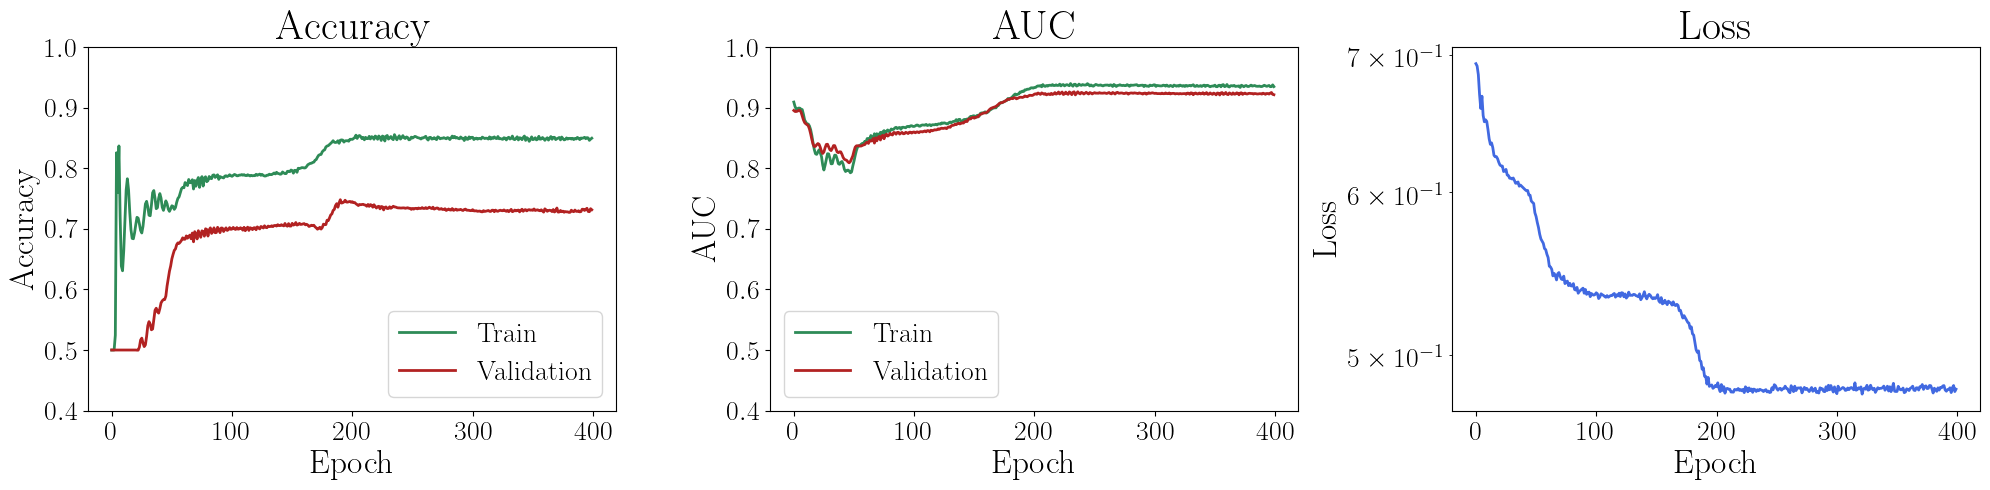

In [311]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

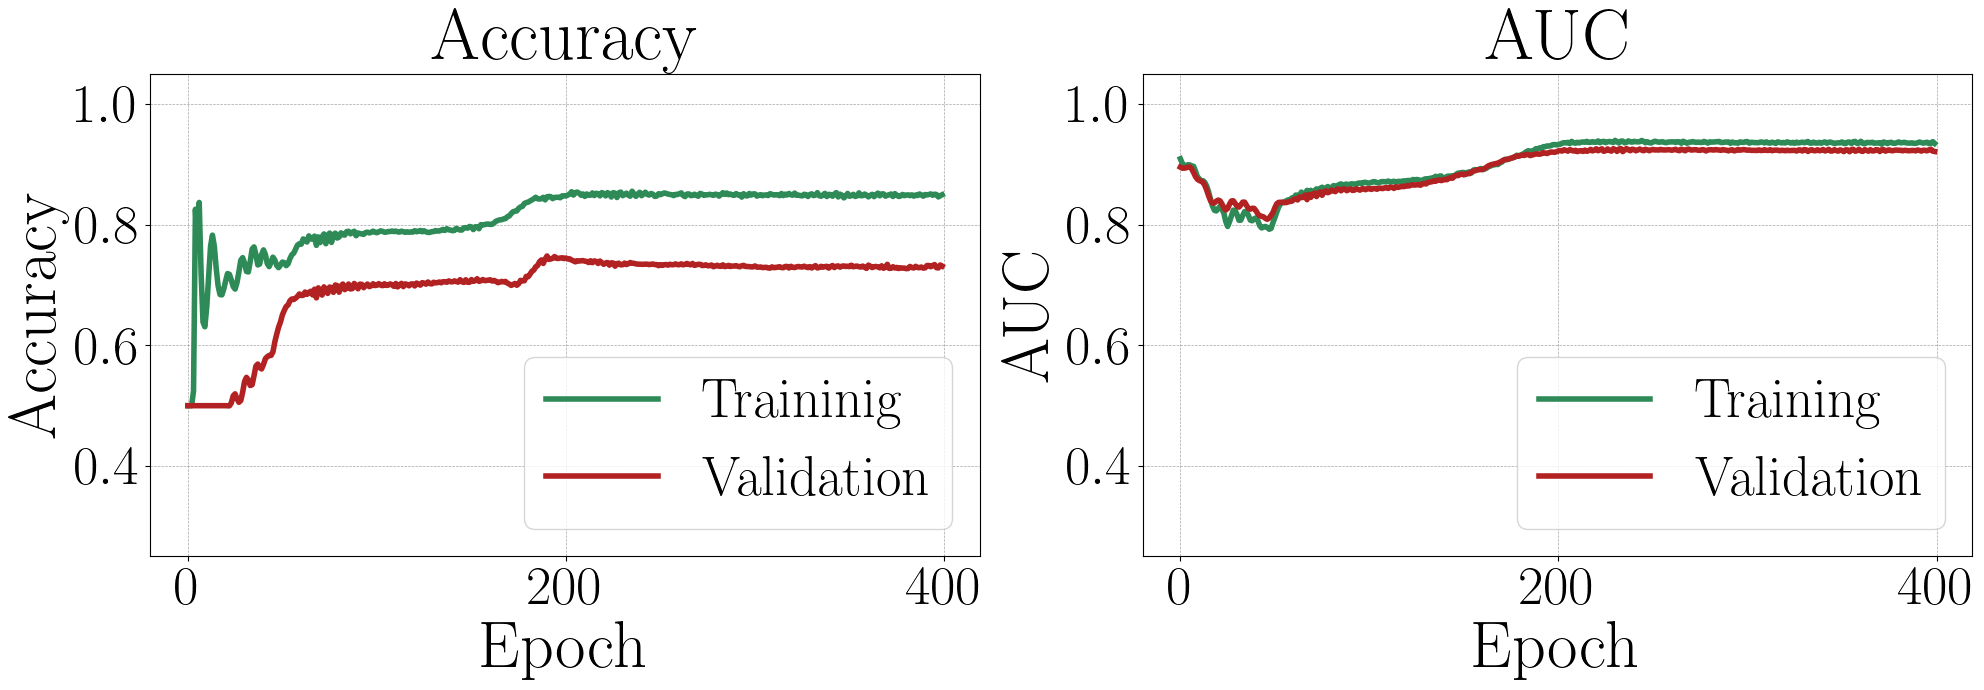

In [312]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

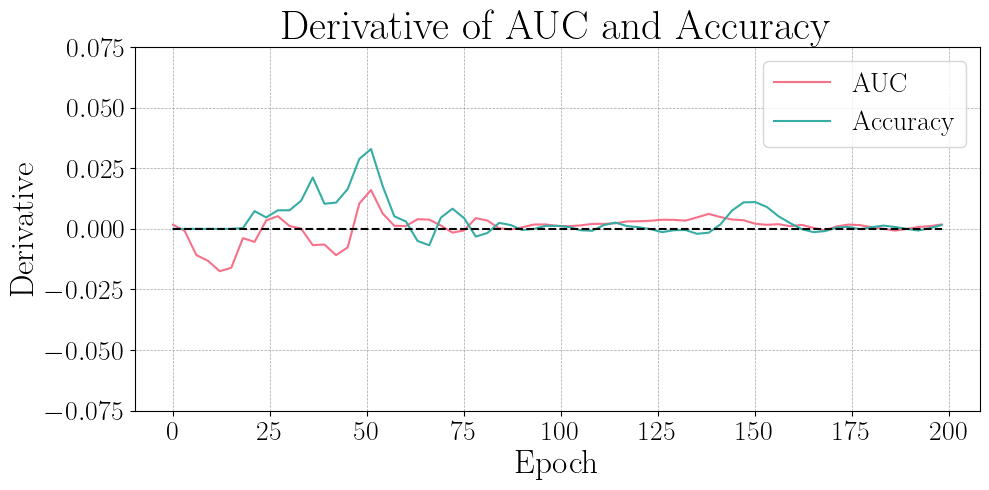

In [160]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [ ]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetConv(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=400, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = NetConv(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## Custom Model (GCN + dropout + BN)

In [313]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetConvPlus(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=False, 
        early_stopping_patience=100,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:36<00:00, 11.07it/s]

Total training time: 29.7614 seconds.
Total validation time: 6.2162 seconds.


In [314]:
best_model = NetConvPlus(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')


The model has 34,336 trainable parameters
Final Test AUC: 0.9751
Final Test ACC: 0.7866


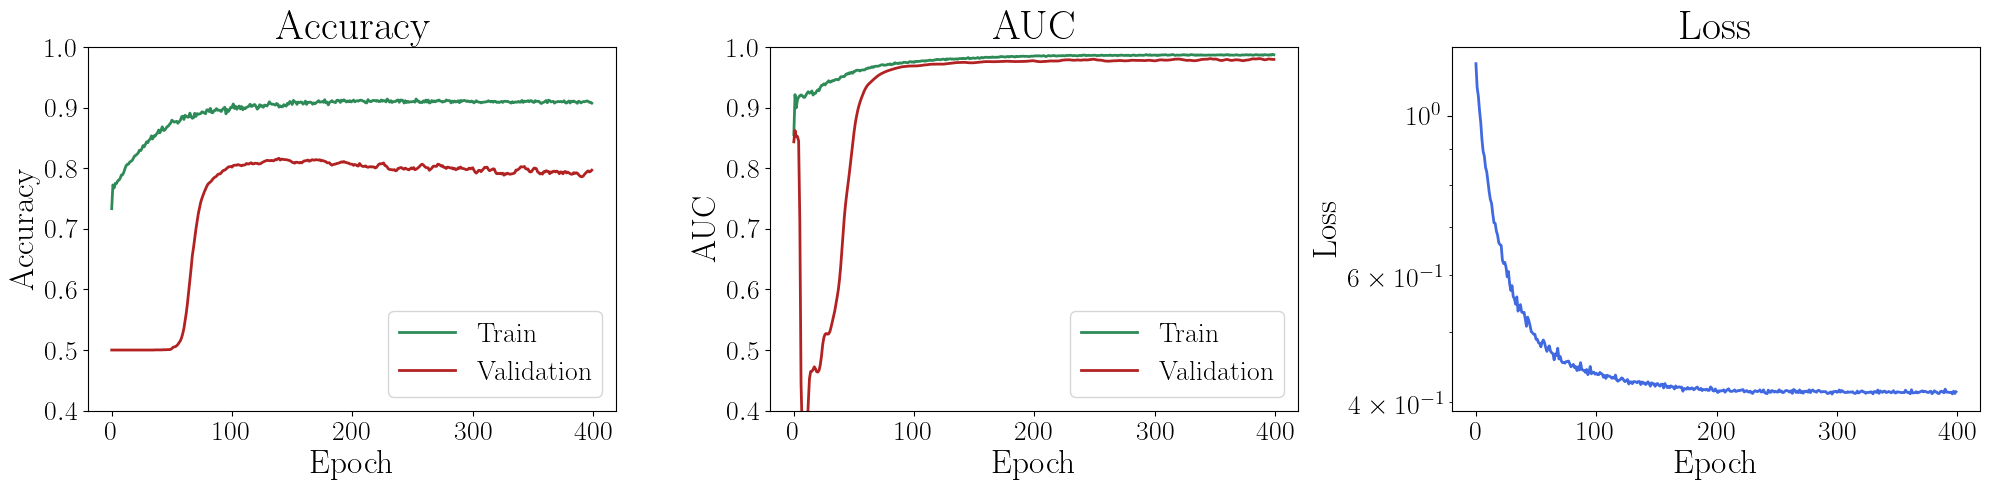

In [315]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

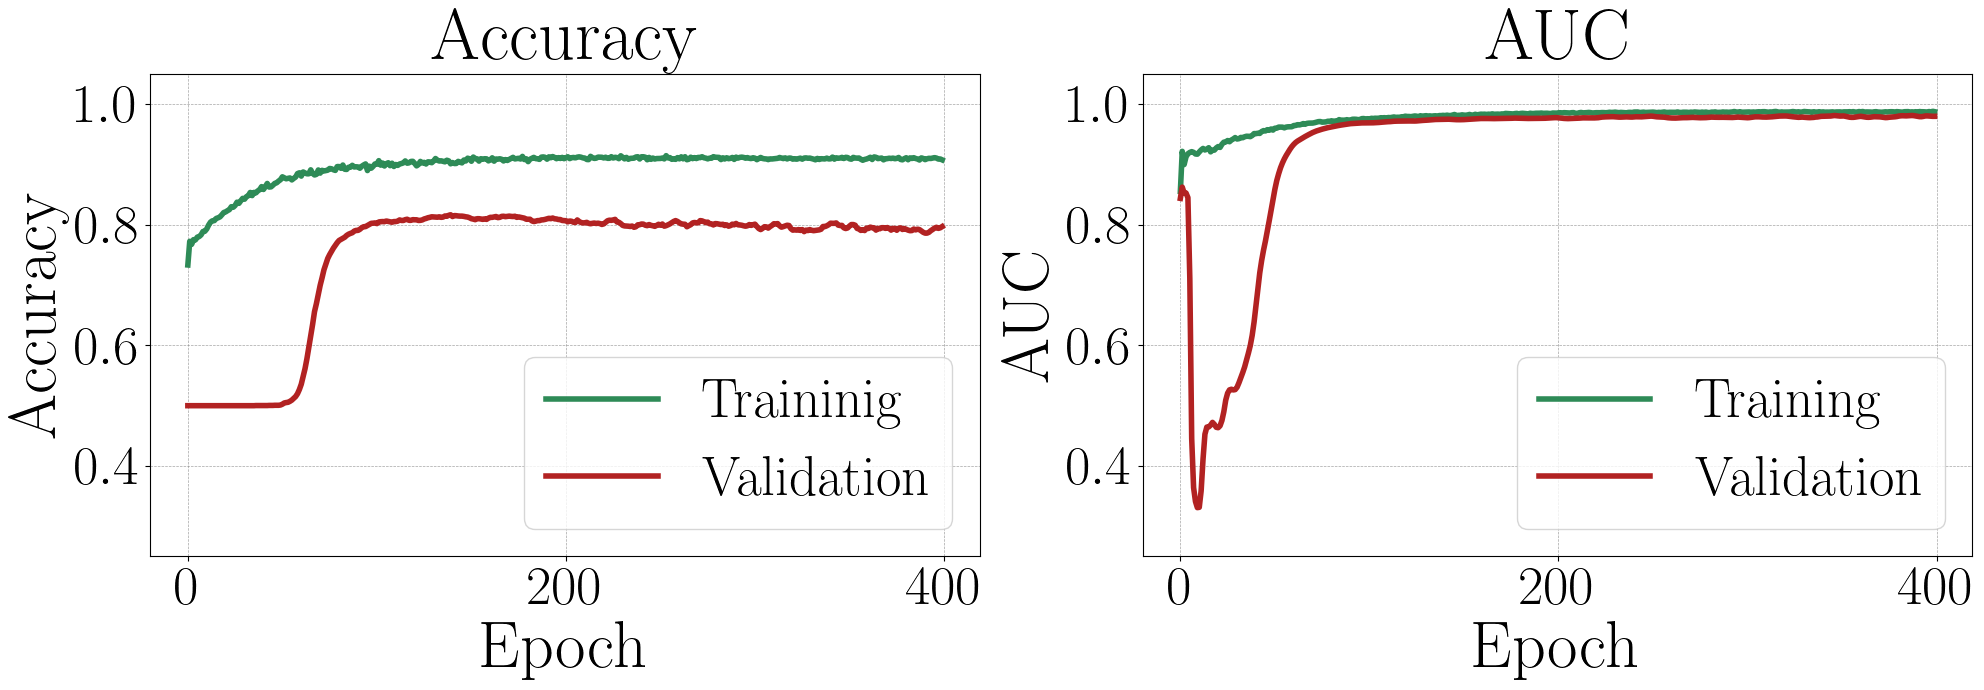

In [316]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

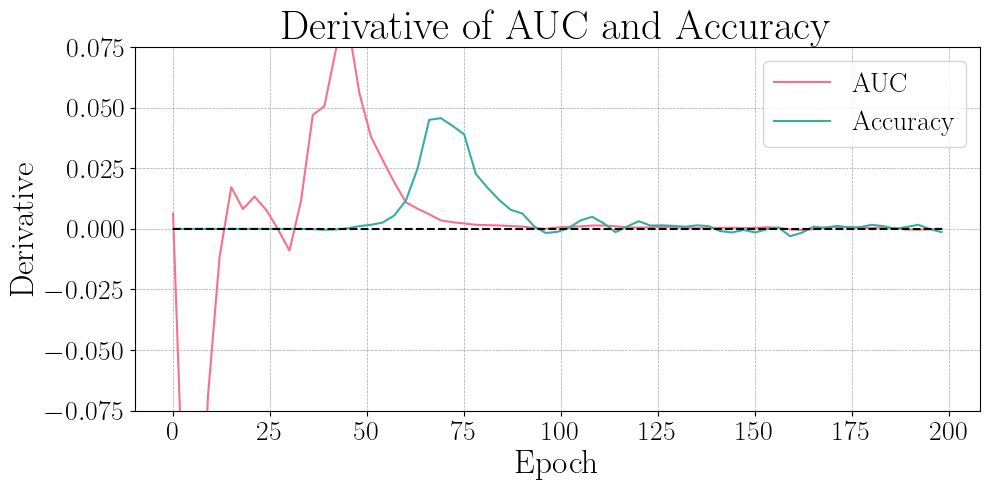

In [247]:
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

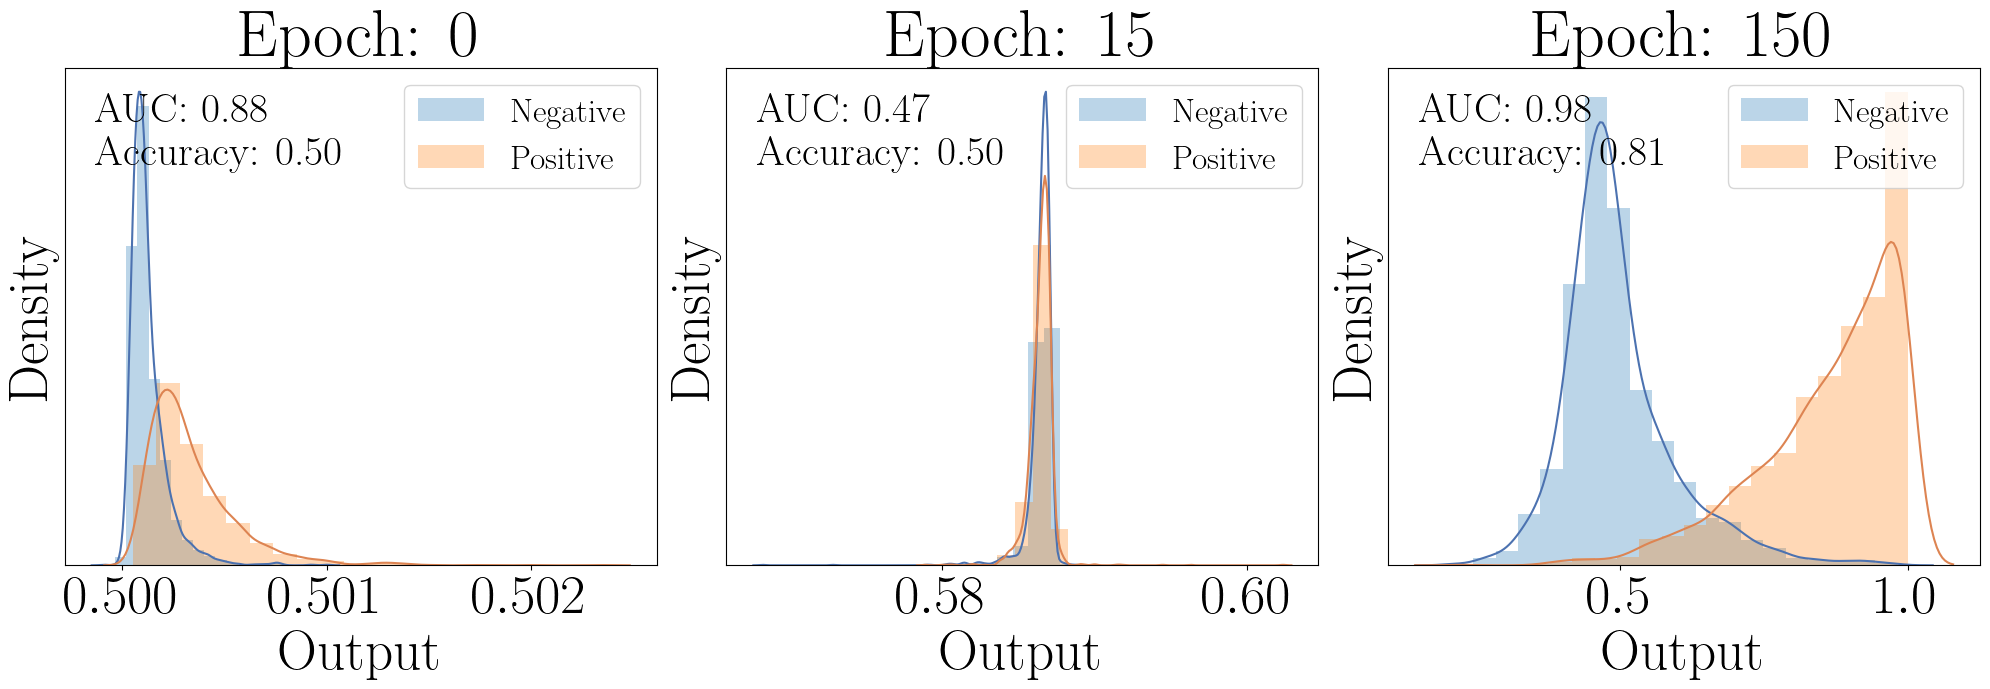

In [321]:
fig, ax = plot_histograms(*get_histograms(train_data, val_data, model, trainer, 
                                          checks=[0, 15, 150]))
fig.show();

### Best AUC and Accuracy

In [ ]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetConvPlus(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = NetConvPlus(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")

### Percentage of Training Data

In [ ]:
# Define percentages
percentages = np.linspace(0.1, 0.9, 9)

# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

for i in percentages:
    auc_scores = []
    acc_scores = []
    
    for _ in range(5): 
        transform = T.Compose([
            T.NormalizeFeatures(),
            T.ToDevice(device),
            T.RandomLinkSplit(num_val=0.05, num_test=1 - 0.05 - i, is_undirected=True,
                              add_negative_train_samples=False),
        ])
        
        dataset = Planetoid("./nets/", name='PubMed', transform=transform)
        train_data, val_data, test_data = dataset[0]
        
        
        model = NetConvPlus(dataset.num_features, 64, 32).to(device)
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and get results
        # Assicurati di passare g_val e g_test alla funzione train_model
        _, _, _, _, _, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=800, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1 
    )
        best_model = NetConvPlus(dataset.num_features, 64, 32).to(device)
        best_model.load_state_dict(trainer.best_model_state_dict)
        final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)

        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)
    
    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))

In [179]:
# Save results, model structure, and percentages to a pickle file
results = {
    'test_accuracy_auc_mean': test_accuracy_auc_mean,
    'test_accuracy_auc_std': test_accuracy_auc_std,
    'test_accuracy_acc_mean': test_accuracy_acc_mean,
    'test_accuracy_acc_std': test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': percentages.tolist()  # Convert numpy array to list for serialization
}

with open('./files/results_and_model_class.pkl', 'wb') as f:
    pickle.dump(results, f)

In [322]:
# Load results and model structure from the pickle file
with open('./files/results_and_model_class.pkl', 'rb') as f:
    results = pickle.load(f)

# Unpack the results
test_accuracy_auc_mean = results['test_accuracy_auc_mean']
test_accuracy_auc_std = results['test_accuracy_auc_std']
test_accuracy_acc_mean = results['test_accuracy_acc_mean']
test_accuracy_acc_std = results['test_accuracy_acc_std']
model_structure = results['model_structure']
percentages = results['percentages']

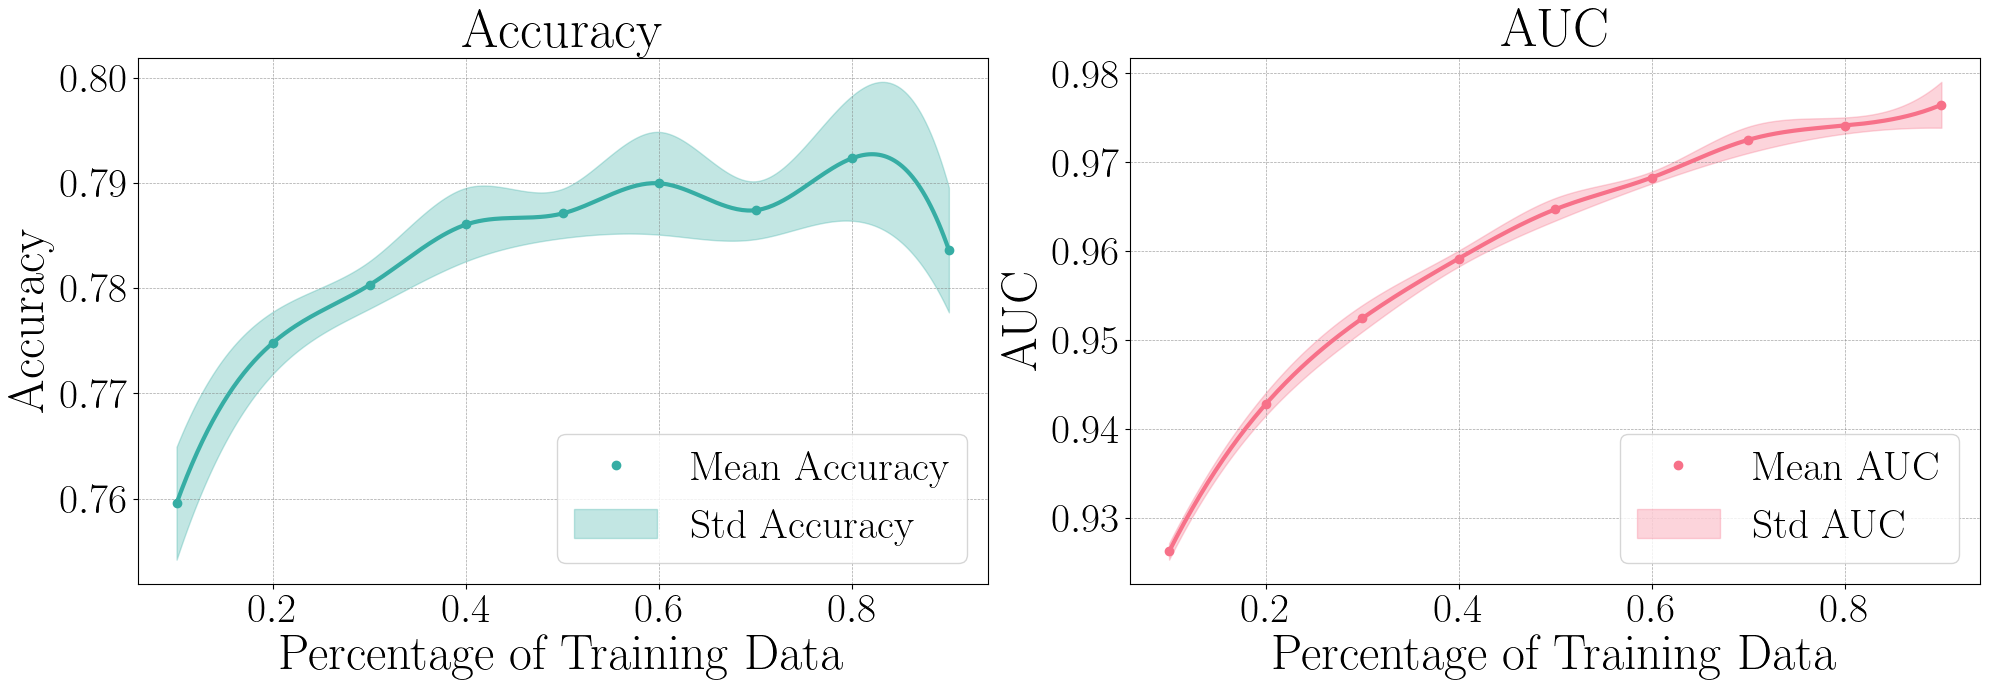

In [327]:
fig, ax = plot_percentage('Percentage of Training Data', percentages, 
                          test_accuracy_auc_mean, test_accuracy_auc_std,
                          test_accuracy_acc_mean, test_accuracy_acc_std)

fig.show();

### Percentage of the Features

In [ ]:
# Initialize lists to store mean and std for AUC and accuracy
test_accuracy_auc_mean = []
test_accuracy_auc_std = []
test_accuracy_acc_mean = []
test_accuracy_acc_std = []

# Define percentages of features to use
feature_percentages = np.linspace(0.1, 0.9, 9)  # e.g., 10%, 20%, ..., 90% of features

# Fixed train, validation, and test split once
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,  # Fixed sizes
                      add_negative_train_samples=False),
])

dataset = Planetoid("./nets/", name='PubMed', transform=transform)
train_data, val_data, test_data = dataset[0]

# Original number of features
num_features = train_data.x.size(1)  # Assuming `x` is the node feature matrix (N x F)
for perc in feature_percentages:
    auc_scores = []
    acc_scores = []

    # Determine the number of features to use for this percentage
    num_features_to_use = min(int(perc * num_features), num_features)  # Ensure it does not exceed actual number of features

    for _ in range(5):  # Repeat 5 times to average
        # Shuffle and select a percentage of features
        selected_features_idx = np.random.permutation(num_features)[:num_features_to_use]
        
        # Create copies of the data and apply the selected features to the dataset
        train_data_copy = train_data.clone()
        val_data_copy = val_data.clone()
        test_data_copy = test_data.clone()

        # Apply the selected features to the dataset
        train_data_copy.x = train_data_copy.x[:, selected_features_idx]
        val_data_copy.x = val_data_copy.x[:, selected_features_idx]
        test_data_copy.x = test_data_copy.x[:, selected_features_idx]

        # Initialize model, optimizer, and criterion
        model = NetConvPlus(num_features_to_use, 64, 32).to(device)  # Update input size
        optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.BCEWithLogitsLoss()

        # Initialize the trainer with the model, optimizer, and criterion
        trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

        # Train the model and evaluate
        _, _, _, _, _, run_timestamp = trainer.train_model(
            train_data=train_data_copy,
            val_data=val_data_copy,
            epochs=800,
            early_stopping=True,
            early_stopping_patience=100,
        )
        best_model = NetConvPlus(num_features_to_use, 64, 32).to(device)
        best_model.load_state_dict(trainer.best_model_state_dict)
        final_test_acc, final_test_auc = trainer.test(test_data_copy)
        
        # Collect results
        auc_scores.append(final_test_auc)
        acc_scores.append(final_test_acc)

    # Compute mean and std for AUC and accuracy for each percentage
    test_accuracy_auc_mean.append(np.mean(auc_scores))
    test_accuracy_auc_std.append(np.std(auc_scores))
    test_accuracy_acc_mean.append(np.mean(acc_scores))
    test_accuracy_acc_std.append(np.std(acc_scores))


In [ ]:
data_to_save = {
    "test_accuracy_auc_mean": test_accuracy_auc_mean,
    "test_accuracy_auc_std": test_accuracy_auc_std,
    "test_accuracy_acc_mean": test_accuracy_acc_mean,
    "test_accuracy_acc_std": test_accuracy_acc_std,
    'model_structure': str(model),  # Save the model structure as a string
    'percentages': feature_percentages.tolist()
}

# Save the data to a pickle file
pickle_file_path = './files/test_accuracy_results_features.pkl'
with open(pickle_file_path, 'wb') as f:
    pickle.dump(data_to_save, f)

In [328]:
# Load the data from the pickle file
with open ('./files/test_accuracy_results_features.pkl', 'rb') as f:
    data = pickle.load(f)

# Unpack the data
test_accuracy_auc_mean = data["test_accuracy_auc_mean"]
test_accuracy_auc_std = data["test_accuracy_auc_std"]
test_accuracy_acc_mean = data["test_accuracy_acc_mean"]
test_accuracy_acc_std = data["test_accuracy_acc_std"]
feature_percentages = data["percentages"]

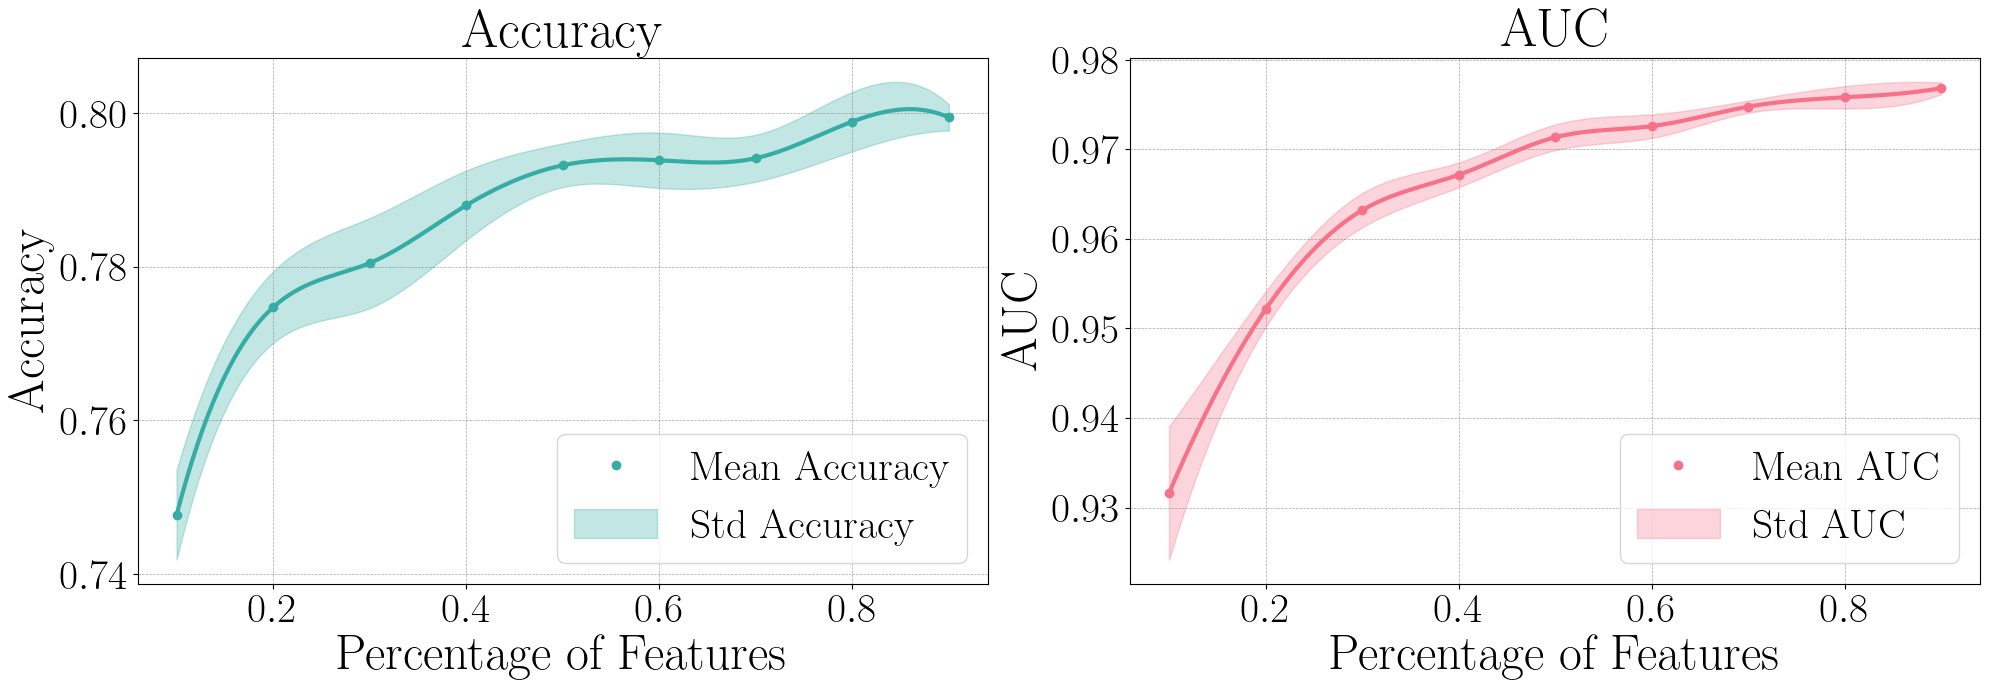

In [329]:
fig, ax = plot_percentage('Percentage of Features', feature_percentages,
                          test_accuracy_auc_mean, test_accuracy_auc_std,
                          test_accuracy_acc_mean, test_accuracy_acc_std)

fig.show();

### Heat Map: Number of Channels

In [22]:
# Download the dataset and apply the transformation
dataset = Planetoid("./nets/", name='PubMed', transform=transform)

hidden_units = [8, 16, 32, 64, 128, 256]
output_units = [4, 8, 16, 32, 64, 128]

results_matrix = np.zeros((len(hidden_units), len(output_units)))

for i, hidden in enumerate(hidden_units):
    for j, output in enumerate(output_units):
        auc, _ = scan_nchannels(dataset, hidden, output)
        results_matrix[i, j] = auc
        print(f"Hidden units: {hidden}, Output units: {output} -> AUC: {auc:.4f}")

100%|██████████| 300/300 [00:30<00:00,  9.84it/s]


Total training time: 25.6183 seconds.
Total validation time: 4.7092 seconds.
Hidden units: 8, Output units: 4 -> AUC: 0.9439


100%|██████████| 300/300 [00:29<00:00, 10.12it/s]


Total training time: 24.8422 seconds.
Total validation time: 4.6557 seconds.
Hidden units: 8, Output units: 8 -> AUC: 0.9549


100%|██████████| 300/300 [00:28<00:00, 10.39it/s]


Total training time: 24.3343 seconds.
Total validation time: 4.4178 seconds.
Hidden units: 8, Output units: 16 -> AUC: 0.9533


100%|██████████| 300/300 [00:29<00:00, 10.31it/s]


Total training time: 24.5944 seconds.
Total validation time: 4.3766 seconds.
Hidden units: 8, Output units: 32 -> AUC: 0.9448


100%|██████████| 300/300 [00:33<00:00,  8.97it/s]


Total training time: 28.0462 seconds.
Total validation time: 5.1742 seconds.
Hidden units: 8, Output units: 64 -> AUC: 0.9263


100%|██████████| 300/300 [00:53<00:00,  5.58it/s]


Total training time: 44.8903 seconds.
Total validation time: 8.6278 seconds.
Hidden units: 8, Output units: 128 -> AUC: 0.8873


 83%|████████▎ | 249/300 [00:28<00:05,  8.79it/s]


Early stopping at epoch 250.
Hidden units: 16, Output units: 4 -> AUC: 0.9555


100%|██████████| 300/300 [00:31<00:00,  9.46it/s]


Total training time: 26.2076 seconds.
Total validation time: 5.3087 seconds.
Hidden units: 16, Output units: 8 -> AUC: 0.9663


100%|██████████| 300/300 [00:27<00:00, 11.05it/s]


Total training time: 23.0689 seconds.
Total validation time: 3.9376 seconds.
Hidden units: 16, Output units: 16 -> AUC: 0.9667


100%|██████████| 300/300 [00:29<00:00, 10.22it/s]


Total training time: 24.8095 seconds.
Total validation time: 4.4418 seconds.
Hidden units: 16, Output units: 32 -> AUC: 0.9653


100%|██████████| 300/300 [00:34<00:00,  8.70it/s]


Total training time: 29.3731 seconds.
Total validation time: 4.9009 seconds.
Hidden units: 16, Output units: 64 -> AUC: 0.9576


100%|██████████| 300/300 [00:52<00:00,  5.77it/s]


Total training time: 43.5774 seconds.
Total validation time: 8.2066 seconds.
Hidden units: 16, Output units: 128 -> AUC: 0.9299


 81%|████████  | 243/300 [00:24<00:05, 10.08it/s]


Early stopping at epoch 244.
Hidden units: 32, Output units: 4 -> AUC: 0.9580


100%|██████████| 300/300 [00:29<00:00, 10.17it/s]


Total training time: 24.2713 seconds.
Total validation time: 5.1052 seconds.
Hidden units: 32, Output units: 8 -> AUC: 0.9678


100%|██████████| 300/300 [00:30<00:00,  9.82it/s]


Total training time: 25.4489 seconds.
Total validation time: 4.9266 seconds.
Hidden units: 32, Output units: 16 -> AUC: 0.9726


100%|██████████| 300/300 [00:33<00:00,  9.07it/s]


Total training time: 27.4339 seconds.
Total validation time: 5.4088 seconds.
Hidden units: 32, Output units: 32 -> AUC: 0.9744


100%|██████████| 300/300 [00:39<00:00,  7.57it/s]


Total training time: 32.9857 seconds.
Total validation time: 6.4209 seconds.
Hidden units: 32, Output units: 64 -> AUC: 0.9665


100%|██████████| 300/300 [00:58<00:00,  5.17it/s]


Total training time: 48.1632 seconds.
Total validation time: 9.6577 seconds.
Hidden units: 32, Output units: 128 -> AUC: 0.9594


 92%|█████████▏| 276/300 [00:30<00:02,  8.95it/s]


Early stopping at epoch 277.
Hidden units: 64, Output units: 4 -> AUC: 0.9609


 95%|█████████▌| 285/300 [00:32<00:01,  8.79it/s]


Early stopping at epoch 286.
Hidden units: 64, Output units: 8 -> AUC: 0.9617


100%|██████████| 300/300 [00:31<00:00,  9.42it/s]


Total training time: 26.6579 seconds.
Total validation time: 4.9294 seconds.
Hidden units: 64, Output units: 16 -> AUC: 0.9712


100%|██████████| 300/300 [00:32<00:00,  9.20it/s]


Total training time: 27.3127 seconds.
Total validation time: 5.0621 seconds.
Hidden units: 64, Output units: 32 -> AUC: 0.9749


100%|██████████| 300/300 [00:36<00:00,  8.32it/s]


Total training time: 30.1471 seconds.
Total validation time: 5.6718 seconds.
Hidden units: 64, Output units: 64 -> AUC: 0.9762


100%|██████████| 300/300 [00:53<00:00,  5.64it/s]


Total training time: 44.1305 seconds.
Total validation time: 8.8352 seconds.
Hidden units: 64, Output units: 128 -> AUC: 0.9710


 88%|████████▊ | 265/300 [00:36<00:04,  7.21it/s]


Early stopping at epoch 266.
Hidden units: 128, Output units: 4 -> AUC: 0.9542


100%|██████████| 300/300 [00:40<00:00,  7.42it/s]


Total training time: 31.5110 seconds.
Total validation time: 8.6801 seconds.
Hidden units: 128, Output units: 8 -> AUC: 0.9675


 97%|█████████▋| 292/300 [00:37<00:01,  7.70it/s]


Early stopping at epoch 293.
Hidden units: 128, Output units: 16 -> AUC: 0.9774


100%|██████████| 300/300 [00:41<00:00,  7.16it/s]


Total training time: 32.5833 seconds.
Total validation time: 9.1180 seconds.
Hidden units: 128, Output units: 32 -> AUC: 0.9783


100%|██████████| 300/300 [00:44<00:00,  6.71it/s]


Total training time: 35.2254 seconds.
Total validation time: 9.2925 seconds.
Hidden units: 128, Output units: 64 -> AUC: 0.9739


100%|██████████| 300/300 [00:56<00:00,  5.28it/s]


Total training time: 46.8541 seconds.
Total validation time: 9.6897 seconds.
Hidden units: 128, Output units: 128 -> AUC: 0.9756


 97%|█████████▋| 292/300 [00:48<00:01,  6.08it/s]


Early stopping at epoch 293.
Hidden units: 256, Output units: 4 -> AUC: 0.9627


 95%|█████████▌| 285/300 [00:47<00:02,  6.06it/s]


Early stopping at epoch 286.
Hidden units: 256, Output units: 8 -> AUC: 0.9683


100%|██████████| 300/300 [00:51<00:00,  5.87it/s]


Total training time: 38.7509 seconds.
Total validation time: 12.1031 seconds.
Hidden units: 256, Output units: 16 -> AUC: 0.9722


100%|██████████| 300/300 [00:52<00:00,  5.74it/s]


Total training time: 39.4134 seconds.
Total validation time: 12.5782 seconds.
Hidden units: 256, Output units: 32 -> AUC: 0.9772


100%|██████████| 300/300 [00:55<00:00,  5.42it/s]


Total training time: 41.9240 seconds.
Total validation time: 13.1614 seconds.
Hidden units: 256, Output units: 64 -> AUC: 0.9736


100%|██████████| 300/300 [01:09<00:00,  4.31it/s]

Total training time: 55.8254 seconds.
Total validation time: 13.5652 seconds.
Hidden units: 256, Output units: 128 -> AUC: 0.9702


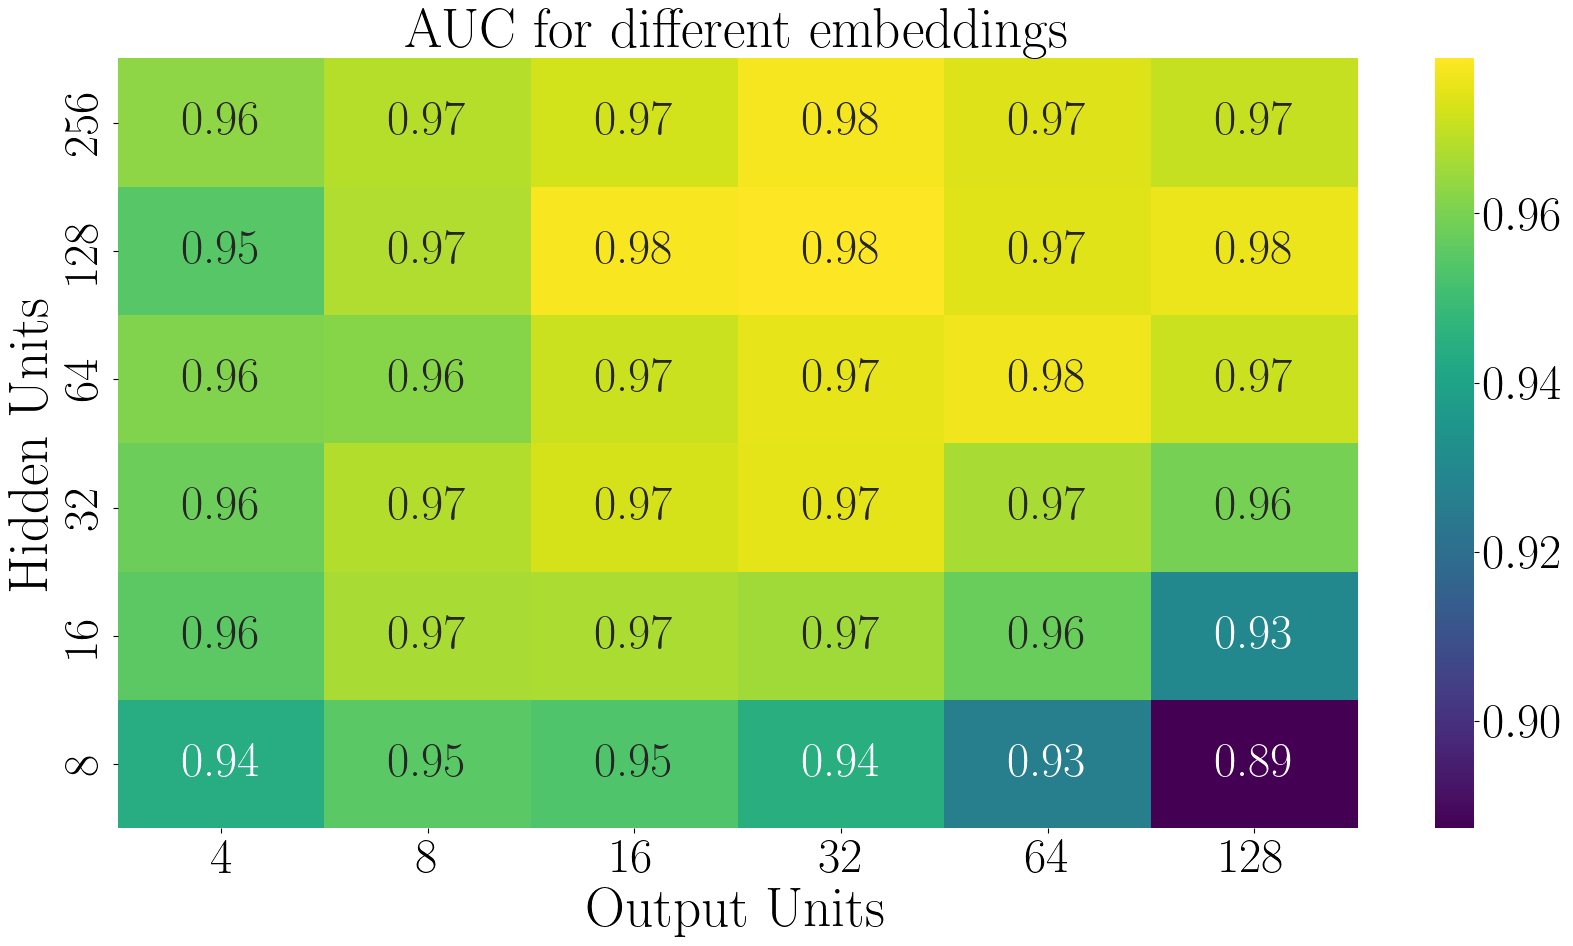

In [28]:
plt.figure(figsize=(20, 10))
ax = sns.heatmap(
    results_matrix, 
    annot=True, 
    xticklabels=output_units, 
    yticklabels=hidden_units, 
    cmap='viridis', 
    annot_kws={"size": 35}  # Font size for cell annotations
)

# Set x and y tick label font sizes
ax.tick_params(axis='x', labelsize=35)  # X-axis tick labels font size
ax.tick_params(axis='y', labelsize=35)  # Y-axis tick labels font size
ax.invert_yaxis()

# Set x and y axis label font sizes
plt.xlabel('Output Units', fontsize=40)
plt.ylabel('Hidden Units', fontsize=40)

# Set title font size
plt.title('AUC for different embeddings', fontsize=40)

# Adjust color bar tick label font size
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=35)

### Heat Map: Learning Rate

In [ ]:
# Define learning rates to evaluate
learning_rates = [0.001, 0.01, 0.1, 0.5, 1]
results_matrix = np.zeros((len(learning_rates), 2)) 

# Evaluate the model for different learning rates
for i, lr in enumerate(dataset, learning_rates):
    auc, acc = scan_lr(dataset, lr)
    results_matrix[i, 0] = auc  # AUC
    results_matrix[i, 1] = acc  # Accuracy
    print(f"Learning rate: {lr} -> AUC: {auc:.4f}, Accuracy: {acc:.4f}")

In [ ]:
# Plot AUC results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 0].reshape(-1, 1), annot=True, xticklabels=['AUC'], yticklabels=learning_rates, cmap='viridis')
plt.title('AUC for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

In [ ]:
# Plot Accuracy results
plt.figure(figsize=(12, 6))
sns.heatmap(results_matrix[:, 1].reshape(-1, 1), annot=True, xticklabels=['Accuracy'], yticklabels=learning_rates, cmap='viridis')
plt.title('Accuracy for different Learning Rates')
plt.xlabel('Metric')
plt.ylabel('Learning Rate')

### Scan for Dropout

In [ ]:
dropout_rates = np.linspace(0.1, 0.7, 7)
values = {"Dropout": {}}  

for i in range(10):
    for dropout in dropout_rates:
        if dropout not in values["Dropout"]:
            values["Dropout"][dropout] = {"AUC": [], "Accuracy": []}
        
        auc, acc = scan_dropout(dataset, dropout)
        
        values["Dropout"][dropout]["AUC"].append(auc)
        values["Dropout"][dropout]["Accuracy"].append(acc)

for dropout in values["Dropout"]:
    auc_values = values["Dropout"][dropout]["AUC"]
    acc_values = values["Dropout"][dropout]["Accuracy"]
    
    values["Dropout"][dropout]["MeanAUC"] = np.mean(auc_values)
    values["Dropout"][dropout]["MeanAcc"] = np.mean(acc_values)
    values["Dropout"][dropout]["StdAUC"] = np.std(auc_values)
    values["Dropout"][dropout]["StdAcc"] = np.std(acc_values)

pprint.pprint(values)

In [ ]:
print("Mean AUC and Accuracy for different dropout rates:")
for dropout, metrics in values["Dropout"].items():
    print(f"Dropout {dropout}: Mean AUC = {metrics['MeanAUC']}, Mean Accuracy = {metrics['MeanAcc']}")
    print(f"Dropout {dropout}: Std AUC = {metrics['StdAUC']}, Std Accuracy = {metrics['StdAcc']}")

In [ ]:
dropout_rates = list(values["Dropout"].keys())
test_accuracy_auc_mean = [np.mean(values["Dropout"][dropout]["AUC"]) for dropout in dropout_rates]
test_accuracy_auc_std = [np.std(values["Dropout"][dropout]["AUC"]) for dropout in dropout_rates]
test_accuracy_acc_mean = [np.mean(values["Dropout"][dropout]["Accuracy"]) for dropout in dropout_rates]
test_accuracy_acc_std = [np.std(values["Dropout"][dropout]["Accuracy"]) for dropout in dropout_rates]

# Plotting AUC results with shaded standard deviation area
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, test_accuracy_auc_mean, label='AUC Mean', color='blue', marker='o')
plt.fill_between(dropout_rates, 
                 np.array(test_accuracy_auc_mean) - np.array(test_accuracy_auc_std),
                 np.array(test_accuracy_auc_mean) + np.array(test_accuracy_auc_std),
                 color='blue', label="Learning rate", alpha=0.2)  # Area di deviazione standard per AUC
plt.xlabel('Dropout Rate')
plt.ylabel('AUC Score')
plt.title('Mean AUC for Different Dropout Rates')
plt.grid(True)
plt.legend()
plt.show()

## Attention-Based Model

In [206]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetAttention(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1
    )

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:13<00:00,  5.46it/s]

Total training time: 57.6149 seconds.
Total validation time: 15.3774 seconds.


In [207]:
best_model = NetAttention(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

The model has 68,832 trainable parameters
Final Test AUC: 0.9546
Final Test ACC: 0.8056


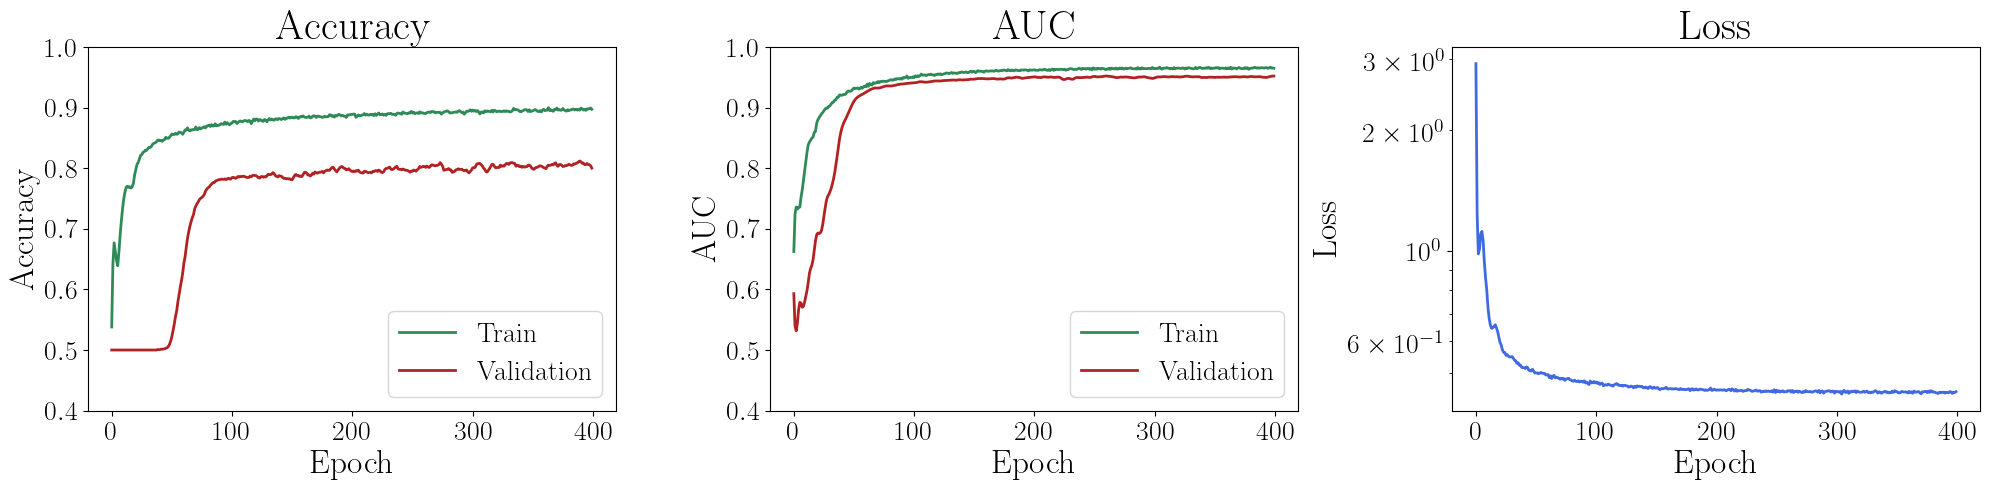

In [208]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

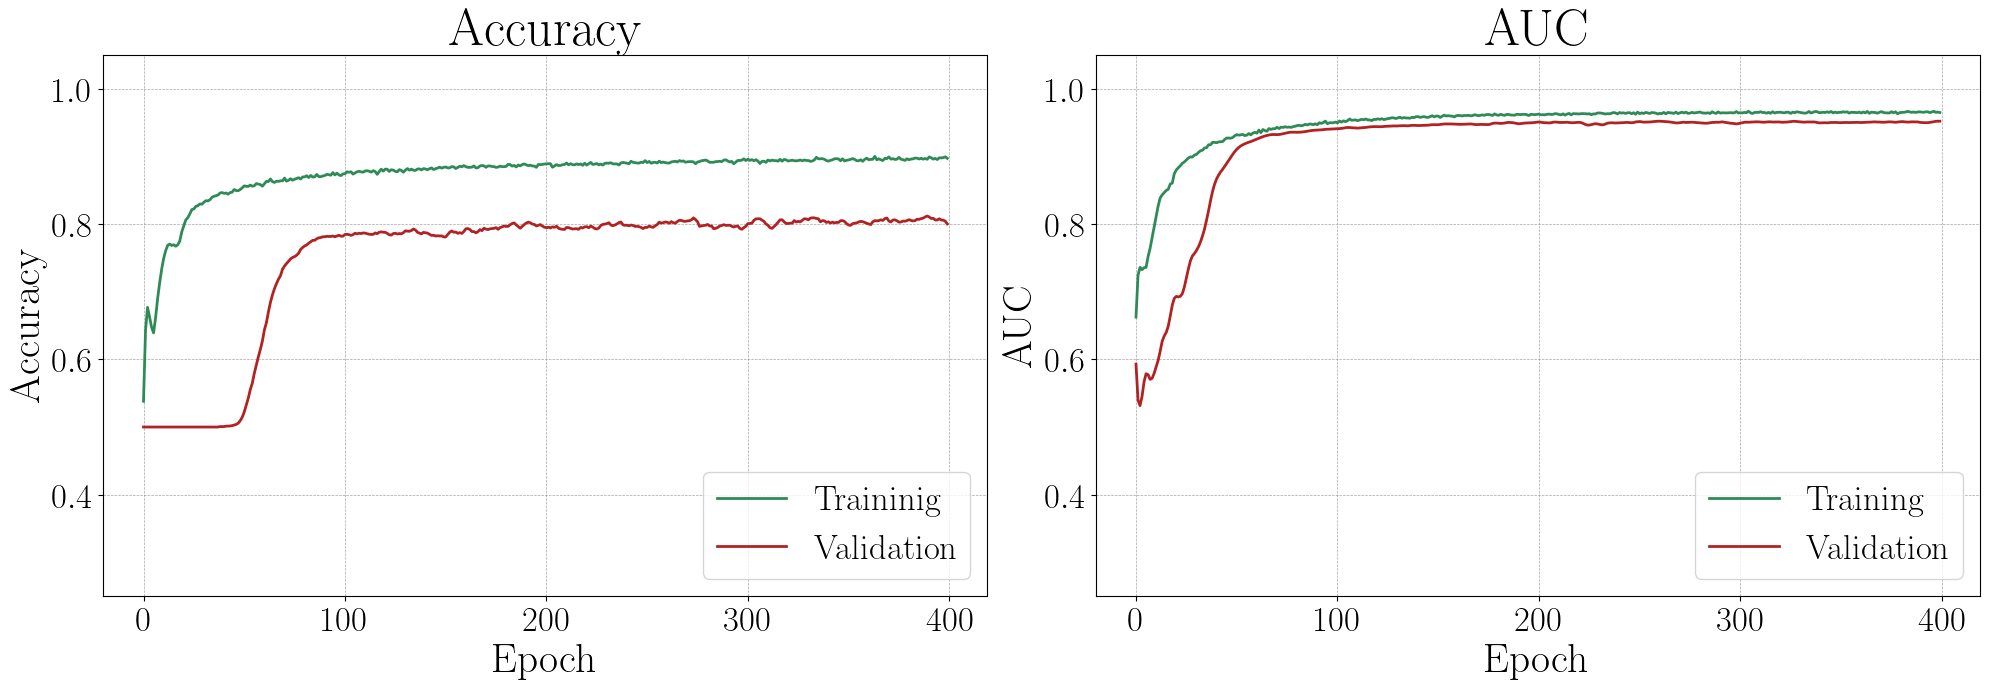

In [209]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

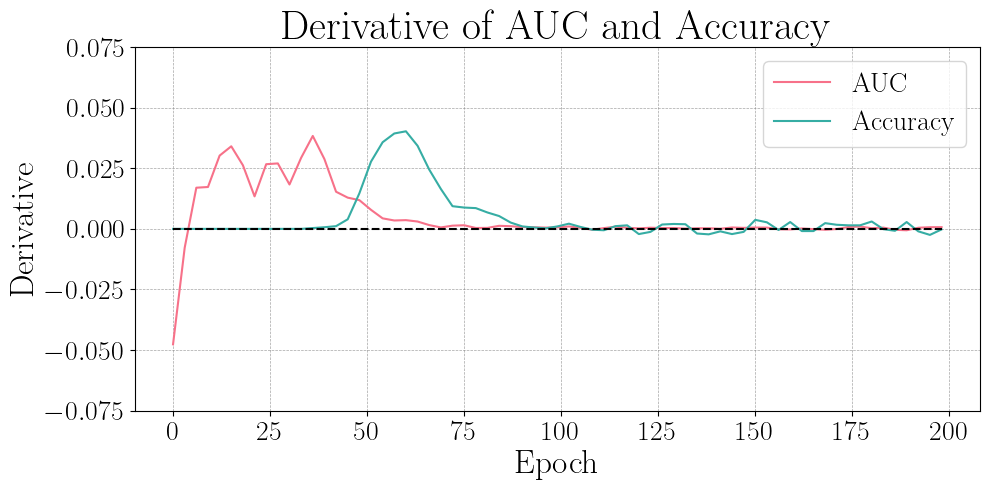

In [210]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [ ]:
test_acc, test_auc = [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetAttention(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=100,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=False
        )
    best_model = NetAttention(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## Recurrent Layer Model

In [ ]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetRecurrent(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=400, 
        early_stopping=True, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1
    )

In [ ]:
best_model = NetRecurrent(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')

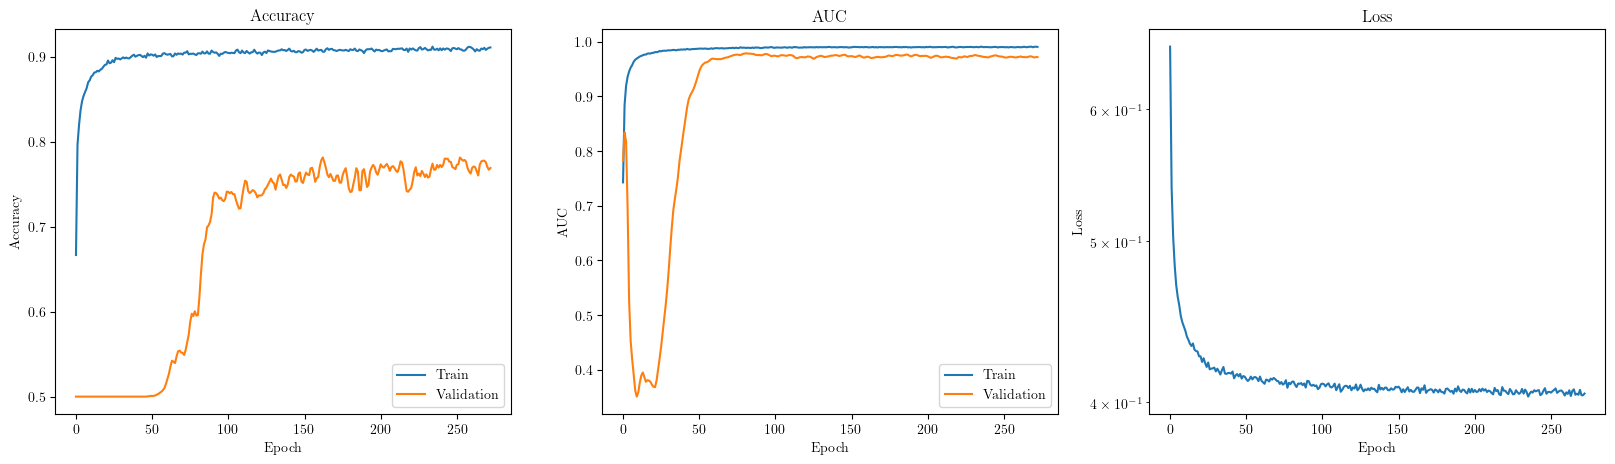

In [24]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

In [ ]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

In [ ]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [ ]:
test_acc, test_auc, test_mrr = [], [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetRecurrent(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=200,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=True
        )
    best_model = NetRecurrent(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


## VAE model

In [30]:
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64      # Number of hidden channels
out_channels = 32         # Number of output features

# Create the model instance (Variational Autoencoder)
model = NetVAE(in_channels, hidden_channels, out_channels).to(device)

# Set optimizer and critereon
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Initialize the trainer
trainer = TrainerVAE(model=model, optimizer=optimizer, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
    train_data=train_data, 
    val_data=val_data, 
    epochs=800, 
    early_stopping=True, 
    early_stopping_patience=200,
    
)

 53%|█████▎    | 423/800 [00:21<00:18, 19.88it/s]

Early stopping at epoch 424.


In [31]:
best_model = NetVAE(in_channels, hidden_channels, out_channels).to(device)
best_model.load_state_dict(trainer.best_model_state_dict)
print(f'The model has {count_parameters(best_model):,} trainable parameters')

# Test the model with the test data
final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
print(f'Final Test AUC: {final_test_auc:.4f}')
print(f'Final Test ACC: {final_test_acc:.4f}')


The model has 36,352 trainable parameters
Final Test AUC: 0.9584
Final Test ACC: 0.7816


C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_23464\199895432.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


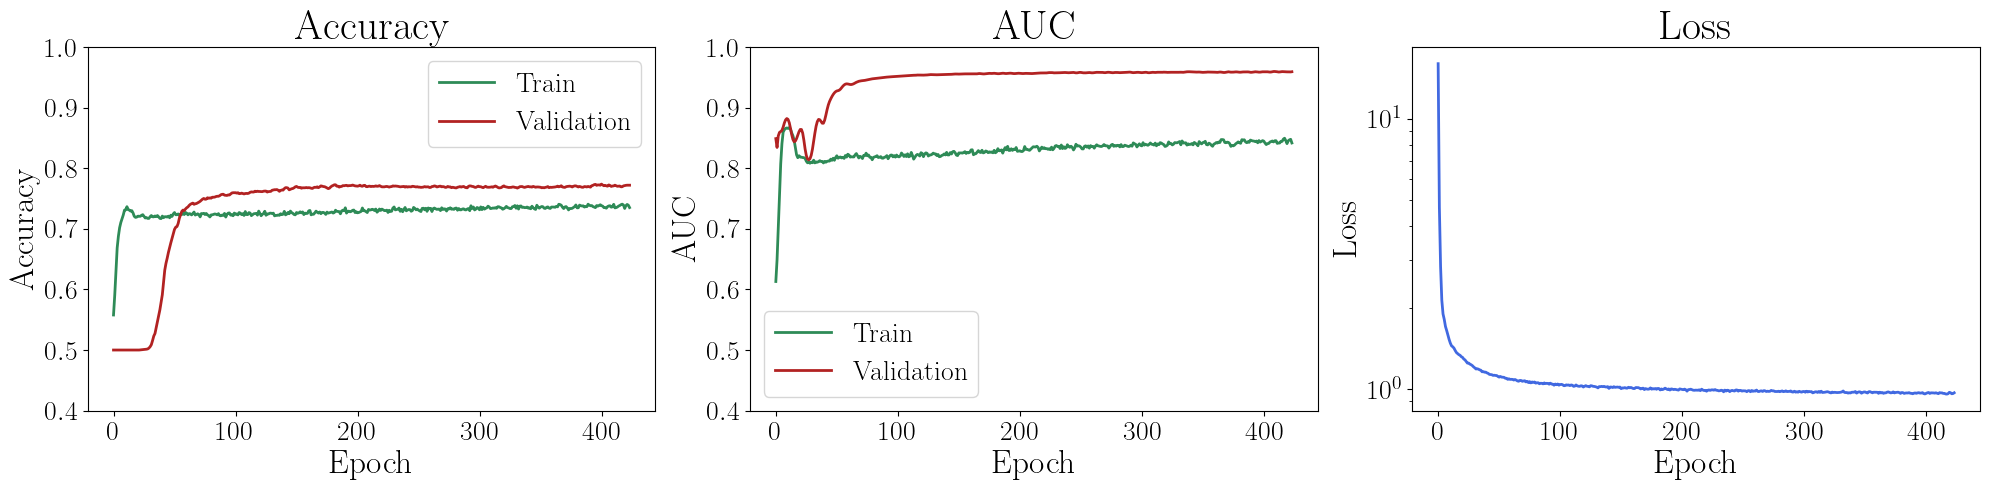

In [32]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_23464\355101546.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


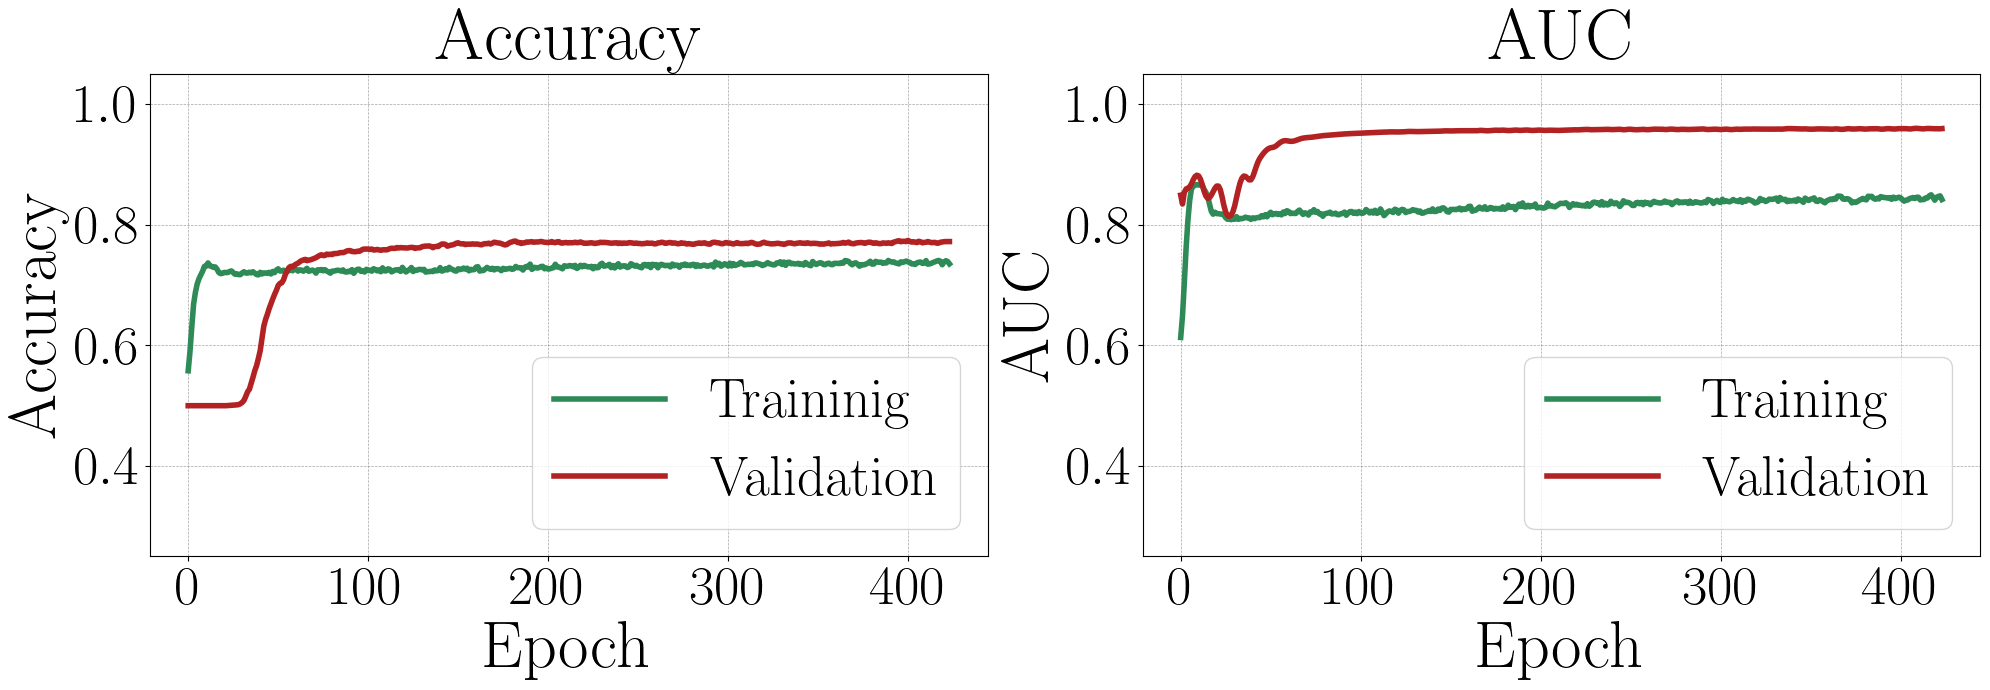

In [33]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=False)
fig.show();

C:\Users\Lorenzo Vigorelli\AppData\Local\Temp\ipykernel_23464\3096303298.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


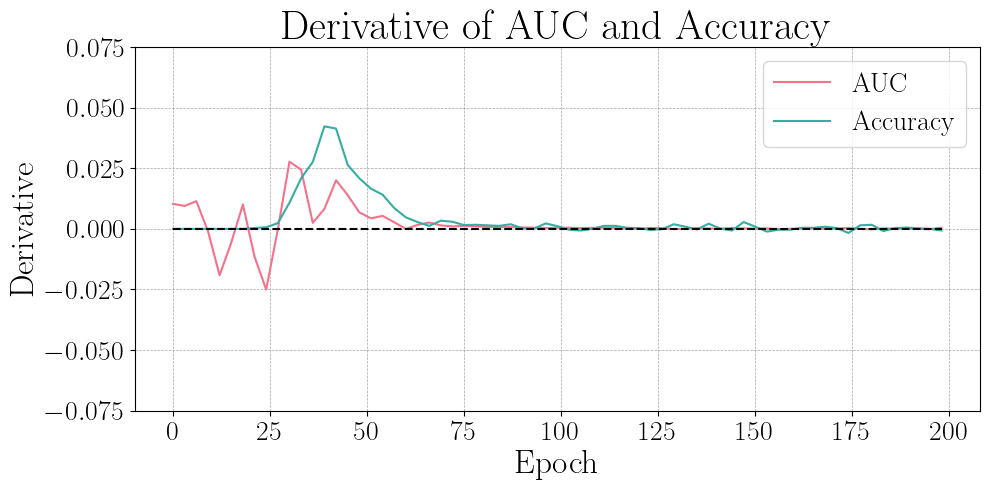

In [34]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

### Best AUC and accuracy

In [36]:
test_acc, test_auc, test_mrr = [], [], []
for i in tqdm(range(50)):
    # Hyperparameters of the network
    run_timestamp = None
    in_channels = num_features  # Number of input features
    hidden_channels = 64 # Number of hidden channels
    out_channels = 32 # Number of output features

    # Create the model instance
    model = NetVAE(in_channels, hidden_channels, out_channels)

    # Set optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
    criterion = torch.nn.BCEWithLogitsLoss()  

    # Initialize trainer
    trainer = TrainerVAE(model=model, optimizer=optimizer, device=device)

    # Train the model
    train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
            train_data, 
            val_data,  
            epochs=800, 
            early_stopping=True, 
            early_stopping_patience=100,
            corrupt=False, 
            corrupt_percentage=0.1,
            save_best_model=True
        )
    best_model = NetVAE(in_channels, hidden_channels, out_channels).to(device)
    best_model.load_state_dict(trainer.best_model_state_dict)
    # Test the model with the test data
    final_test_acc, final_test_auc = trainer.test(test_data, corrupt=False)
    test_acc.append(final_test_acc)
    test_auc.append(final_test_auc)

mean_test_acc = np.mean(test_acc)
mean_test_auc = np.mean(test_auc)
std_test_acc = np.std(test_acc)
std_test_auc = np.std(test_auc)
print(f'Mean Test AUC: {mean_test_auc:.4f} ± {std_test_auc:.4f}')
print(f'Mean Test ACC: {mean_test_acc:.4f} ± {std_test_acc:.4f}')
print(f"The std of the test AUC is {std_test_auc:.4f}")
print(f"The std of the test ACC is {std_test_acc:.4f}")


  2%|▏         | 1/50 [00:09<07:24,  9.06s/it]

Early stopping at epoch 179.


  4%|▍         | 2/50 [00:21<08:51, 11.08s/it]

Early stopping at epoch 230.


  6%|▌         | 3/50 [00:31<08:20, 10.66s/it]

Early stopping at epoch 174.


  8%|▊         | 4/50 [00:41<07:53, 10.30s/it]

Early stopping at epoch 173.


 10%|█         | 5/50 [00:52<08:00, 10.68s/it]

Early stopping at epoch 203.


 12%|█▏        | 6/50 [01:02<07:33, 10.30s/it]

Early stopping at epoch 168.


 14%|█▍        | 7/50 [01:12<07:17, 10.16s/it]

Early stopping at epoch 170.


 16%|█▌        | 8/50 [01:22<07:07, 10.19s/it]

Early stopping at epoch 183.


 18%|█▊        | 9/50 [01:36<07:47, 11.39s/it]

Early stopping at epoch 245.


 20%|██        | 10/50 [01:47<07:26, 11.16s/it]

Early stopping at epoch 185.


 22%|██▏       | 11/50 [01:57<07:04, 10.90s/it]

Early stopping at epoch 177.


 24%|██▍       | 12/50 [02:08<06:52, 10.85s/it]

Early stopping at epoch 186.


 26%|██▌       | 13/50 [02:17<06:21, 10.30s/it]

Early stopping at epoch 154.


 28%|██▊       | 14/50 [02:26<06:04, 10.12s/it]

Early stopping at epoch 174.


 30%|███       | 15/50 [02:41<06:35, 11.31s/it]

Early stopping at epoch 247.


 32%|███▏      | 16/50 [02:52<06:30, 11.49s/it]

Early stopping at epoch 207.


 34%|███▍      | 17/50 [03:02<05:58, 10.87s/it]

Early stopping at epoch 162.


 36%|███▌      | 18/50 [03:14<06:01, 11.30s/it]

Early stopping at epoch 214.


 38%|███▊      | 19/50 [03:24<05:38, 10.93s/it]

Early stopping at epoch 173.


 40%|████      | 20/50 [03:35<05:23, 10.80s/it]

Early stopping at epoch 184.


 42%|████▏     | 21/50 [03:46<05:13, 10.81s/it]

Early stopping at epoch 187.


 44%|████▍     | 22/50 [03:56<04:57, 10.62s/it]

Early stopping at epoch 178.


 46%|████▌     | 23/50 [04:08<04:58, 11.04s/it]

Early stopping at epoch 207.


 48%|████▊     | 24/50 [04:18<04:41, 10.81s/it]

Early stopping at epoch 181.


 50%|█████     | 25/50 [04:32<04:57, 11.88s/it]

Early stopping at epoch 247.


 52%|█████▏    | 26/50 [04:42<04:26, 11.11s/it]

Early stopping at epoch 160.


 54%|█████▍    | 27/50 [04:52<04:06, 10.73s/it]

Early stopping at epoch 169.


 56%|█████▌    | 28/50 [05:05<04:16, 11.67s/it]

Early stopping at epoch 240.


 58%|█████▊    | 29/50 [05:15<03:48, 10.89s/it]

Early stopping at epoch 152.


 60%|██████    | 30/50 [05:30<04:03, 12.19s/it]

Early stopping at epoch 261.


 62%|██████▏   | 31/50 [05:40<03:43, 11.74s/it]

Early stopping at epoch 182.


 64%|██████▍   | 32/50 [05:51<03:26, 11.49s/it]

Early stopping at epoch 188.


 66%|██████▌   | 33/50 [06:02<03:09, 11.17s/it]

Early stopping at epoch 178.


 68%|██████▊   | 34/50 [06:15<03:06, 11.68s/it]

Early stopping at epoch 221.


 70%|███████   | 35/50 [06:25<02:49, 11.27s/it]

Early stopping at epoch 176.


 72%|███████▏  | 36/50 [06:40<02:51, 12.28s/it]

Early stopping at epoch 255.


 74%|███████▍  | 37/50 [06:52<02:40, 12.38s/it]

Early stopping at epoch 216.


 76%|███████▌  | 38/50 [07:07<02:38, 13.19s/it]

Early stopping at epoch 261.


 78%|███████▊  | 39/50 [07:17<02:15, 12.29s/it]

Early stopping at epoch 174.


 80%|████████  | 40/50 [07:29<02:01, 12.16s/it]

Early stopping at epoch 204.


 82%|████████▏ | 41/50 [07:42<01:50, 12.24s/it]

Early stopping at epoch 213.


 84%|████████▍ | 42/50 [07:57<01:44, 13.05s/it]

Early stopping at epoch 256.


 86%|████████▌ | 43/50 [08:08<01:26, 12.41s/it]

Early stopping at epoch 186.


 88%|████████▊ | 44/50 [08:23<01:20, 13.36s/it]

Early stopping at epoch 269.


 90%|█████████ | 45/50 [08:32<01:00, 12.03s/it]

Early stopping at epoch 153.


 92%|█████████▏| 46/50 [08:42<00:45, 11.43s/it]

Early stopping at epoch 173.


 94%|█████████▍| 47/50 [08:54<00:34, 11.45s/it]

Early stopping at epoch 195.


 96%|█████████▌| 48/50 [09:07<00:24, 12.02s/it]

Early stopping at epoch 230.


 98%|█████████▊| 49/50 [09:19<00:11, 11.94s/it]

Early stopping at epoch 202.


100%|██████████| 50/50 [09:29<00:00, 11.40s/it]

Early stopping at epoch 180.
Mean Test AUC: 0.9430 ± 0.0077
Mean Test ACC: 0.7610 ± 0.0081
The std of the test AUC is 0.0077
The std of the test ACC is 0.0081


# Barabasi topology

In [56]:
# Create the random graph
g = nx.barabasi_albert_graph(10001, 1)
print(f"Number of edges: {g.number_of_edges()}")

# Create the dataset class
dataset = CustomGraphDataset("./data/Custom", *customGraphData(g))

# Define the transformation
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.10, is_undirected=True,
                     add_negative_train_samples=False),
])

# Apply transformations
dataset.transform = transform
train_data, val_data, test_data = dataset[0]

# Get the number of features
num_features = dataset.num_features

Number of edges: 10000


In [52]:
print("Train data edge index:", train_data.edge_index.shape)
print("Train data edge label index:", train_data.edge_label_index.shape)
print("Val data edge index:", val_data.edge_index.shape)
print("Val data edge label index:", val_data.edge_label_index.shape)
print("Test data edge index:", test_data.edge_index.shape)
print("Test data edge label index:", test_data.edge_label_index.shape)

Train data edge index: torch.Size([2, 10200])
Train data edge label index: torch.Size([2, 5100])
Val data edge index: torch.Size([2, 10200])
Val data edge label index: torch.Size([2, 600])
Test data edge index: torch.Size([2, 10800])
Test data edge label index: torch.Size([2, 1200])


In [53]:
# Hyperparameters of the network
run_timestamp = None
in_channels = num_features  # Number of input features
hidden_channels = 64 # Number of hidden channels
out_channels = 32 # Number of output features

# Create the model instance
model = NetConvPlus(in_channels, hidden_channels, out_channels)

# Set optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  
criterion = torch.nn.BCEWithLogitsLoss()  

# Initialize trainer
trainer = TrainerAE(model=model, optimizer=optimizer, criterion=criterion, device=device)

# Train the model
train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history, run_timestamp = trainer.train_model(
        train_data, 
        val_data,  
        epochs=200, 
        early_stopping=False, 
        early_stopping_patience=200,
        corrupt=False, 
        corrupt_percentage=0.1,
        save_best_model=False
    )

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:04<00:00, 46.99it/s]

Total training time: 3.2033 seconds.
Total validation time: 1.0176 seconds.


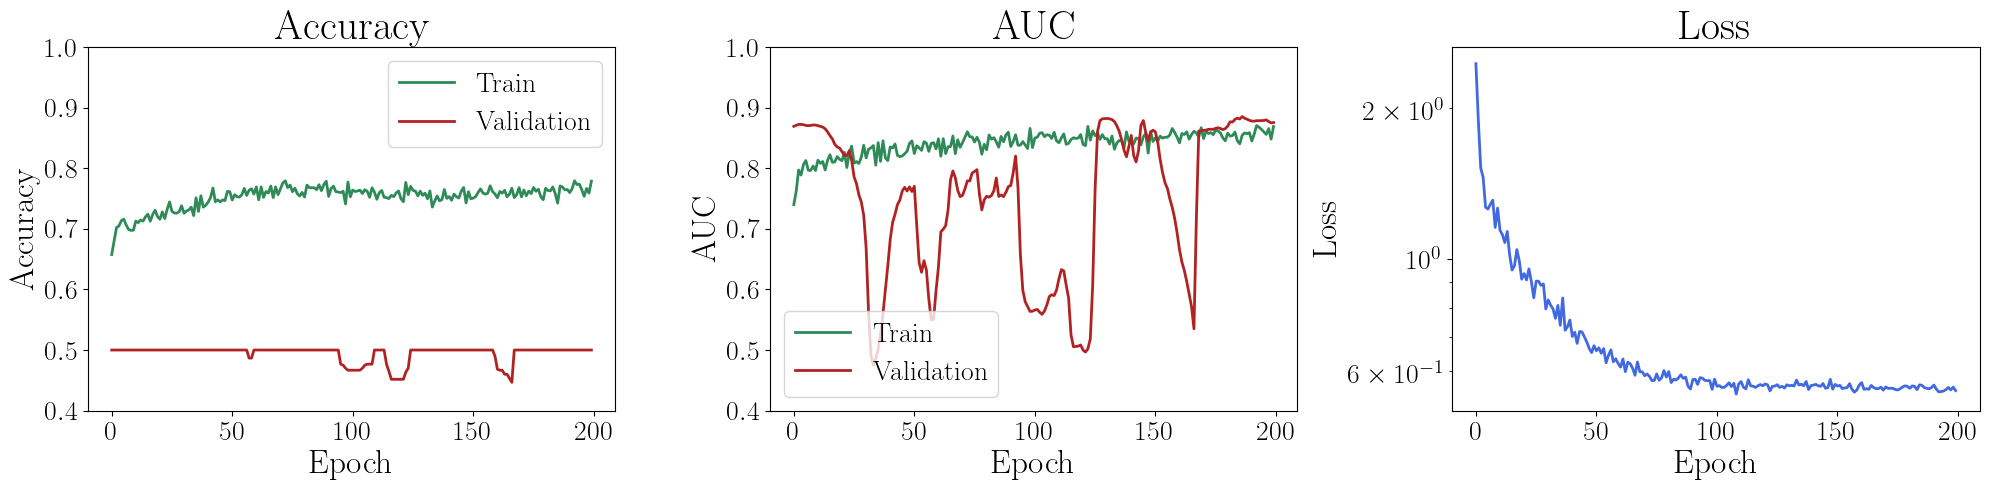

In [54]:
fig, ax = plot_training_ts(train_acc_history, train_auc_history, val_acc_history, val_auc_history, loss_history)
fig.show();

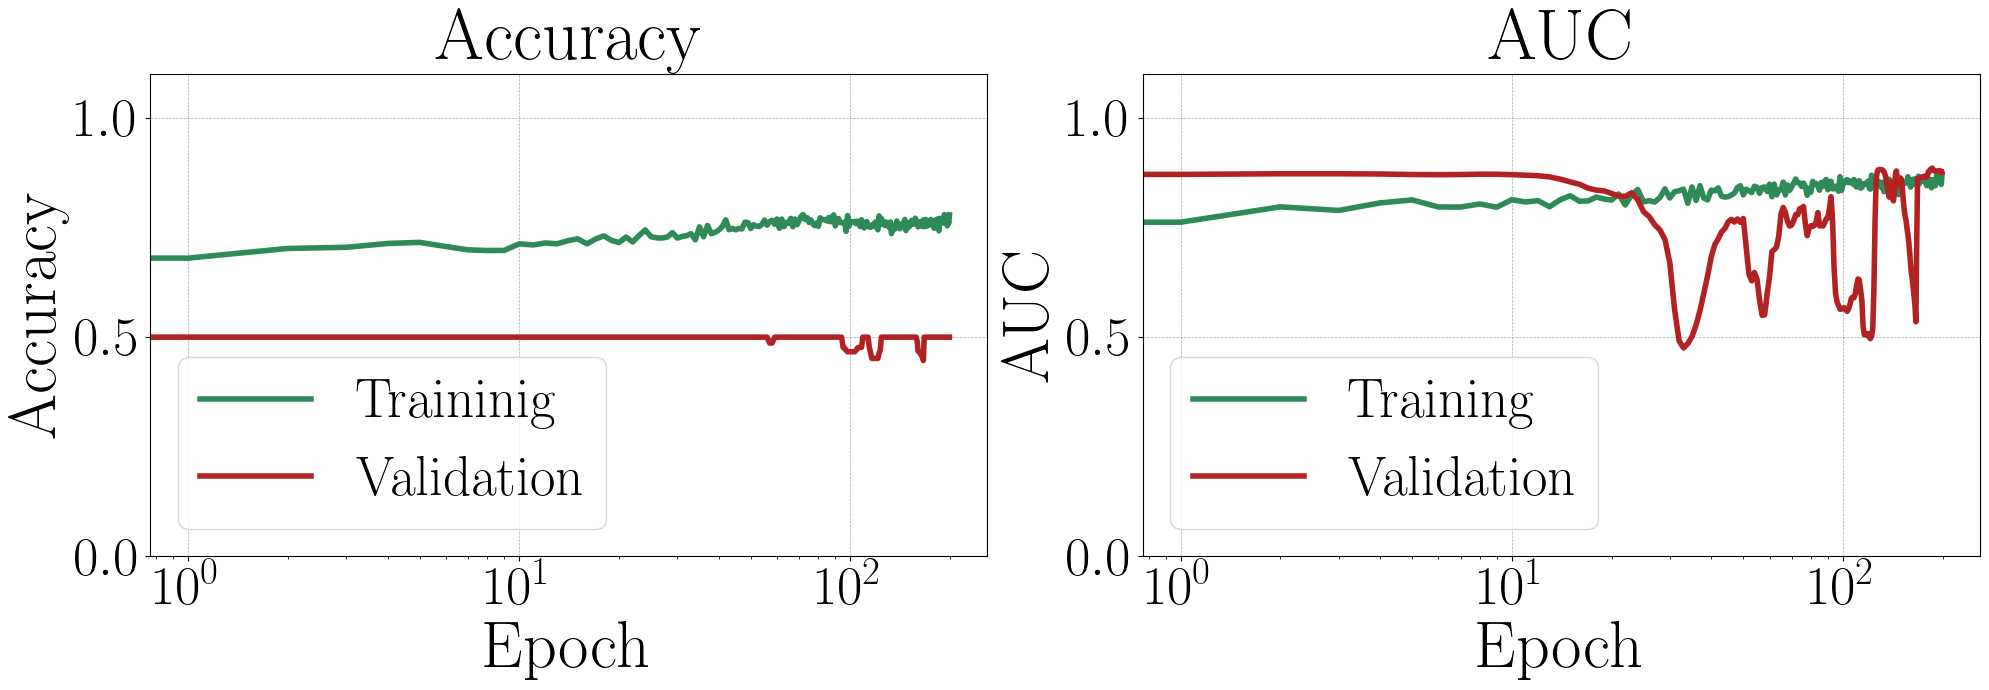

In [55]:
fig, ax = plot_performance(train_acc_history, train_auc_history, 
                           val_acc_history, val_auc_history, xlog=True)

ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 1.1)
ax[0].legend(loc="lower left", fontsize=40)
ax[1].legend(loc="lower left", fontsize=40)
fig.show();

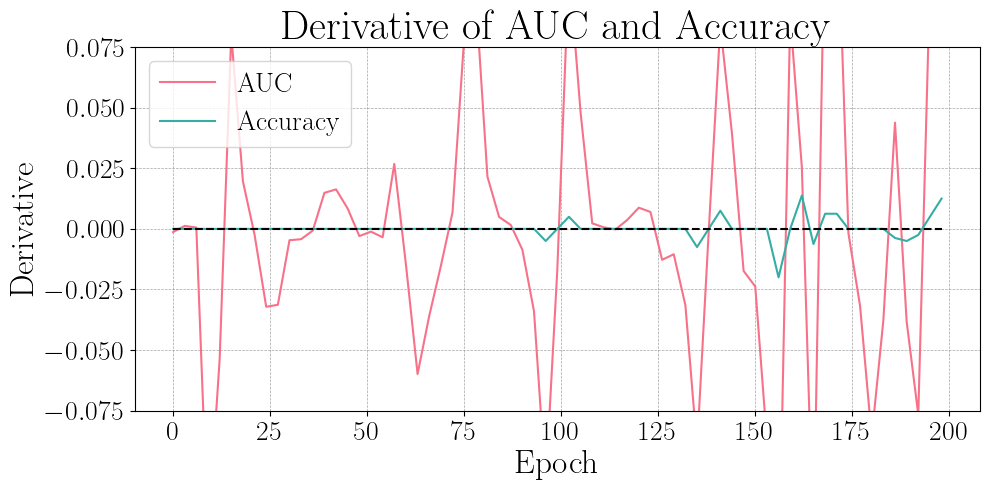

In [48]:
# Derivative of auc and accuracy
fig, ax = plot_derivatives(val_acc_history, val_auc_history)
fig.show();

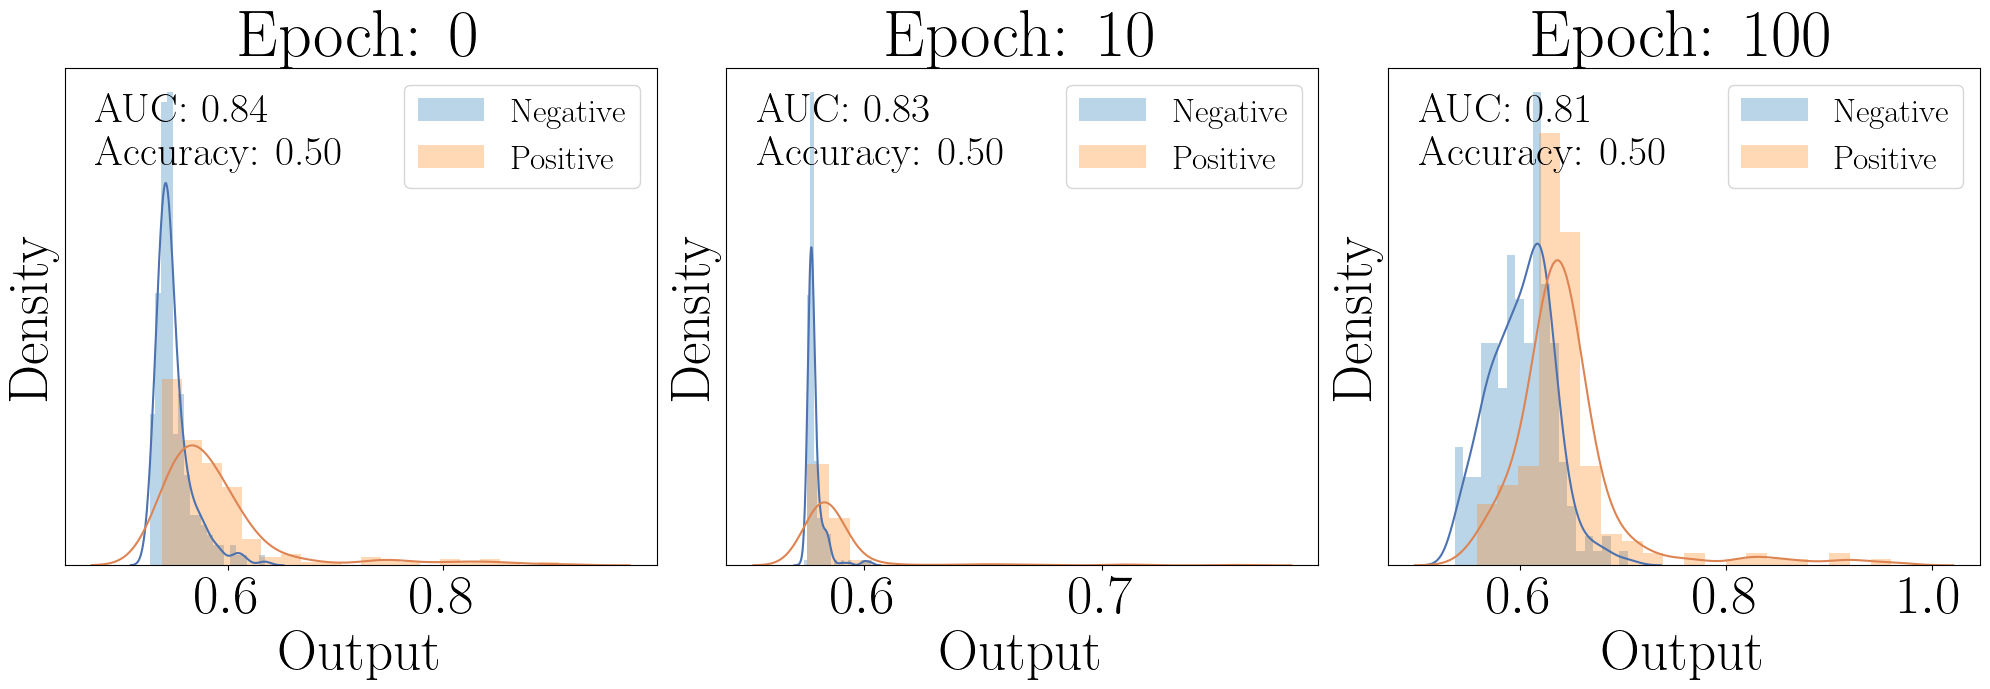

In [49]:
fig, ax = plot_histograms(*get_histograms(train_data, val_data, model, trainer, 
                                          checks=[0, 10, 100]))
fig.show();